This research covers the following topics:

1. Explore a custom LoRA implementation of BERT attention layers for accelerated model training, with a focus on MLM task, and train an SVR model on the obtained embeddings to solve a regression task.

2. Evaluate LSTM model performance in comparison to the custom LoRA implementation.

3. Highlight the impact of additional feature engineering on model performance.

4. Present a performance comparison to underscore the effectiveness of the custom LoRA implementation in enhancing model outcomes.

Start by installing the necessary libraries:

- optuna for hyperparameter search
- simplelemma is a great fast library for multilingual lemmatization; credit: https://github.com/adbar/simplemma
- category_encoders

In [1]:
!pip install optuna simplemma category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.1 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
import os
import numpy as np
import time
from numpy import array, random, arange

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

import math
from typing import List, Dict, Tuple, Optional, Union
import torch.nn as nn
from torch.nn import functional as F

from transformers import BertTokenizer, BertForMaskedLM, BertConfig, AdamW, pipeline
from transformers.models.bert.modeling_bert import BertSelfAttention
from torch.utils.data.sampler import SubsetRandomSampler

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import optuna
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

from simplemma import lemmatize

import scipy.stats as ss
from category_encoders import BinaryEncoder

from gensim.models import FastText

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from functools import partial
from tqdm import tqdm
from tqdm import trange
tqdm_iterator = partial(tqdm, position = 0, leave = True)

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
habr_articles = pd.read_csv('gdrive/MyDrive/ML/projects/habr_articles.csv')

In [6]:
habr_articles.head()

,url,domain,published,author,flow,polling,content_len,title,favs_lognorm,dataset,hub_title,tags,content
0,https://habrahabr.ru/post/18284/,habrahabr.ru,2008-01-01 18:19:00,@Tapac,develop,False,4305,Новогодний подарок блоггерам — WordPress 2.3.2,-1.344075,train,WordPress,"['wordpress', 'update', 'secure', 'обновление'...",Как всегда я плетусь в самом конце WP-движения...
1,https://habrahabr.ru/post/18285/,habrahabr.ru,2008-01-01 18:30:00,@DezmASter,design,False,7344,"Сумасшедшие яйца, или сервис для отслеживания ...",-0.831946,train,Интерфейсы,"['crazyegg', 'веб 2.0', 'юзабилити', 'интерфей...",Сегодняшняя заметка будет о сервисе отслеживан...
2,https://habrahabr.ru/post/18286/,habrahabr.ru,2008-01-01 18:34:00,@DezmASter,design,False,8431,"Сумасшедшие яйца, или сервис для отслеживания ...",1.794023,train,Интерфейсы,"['crazyegg', 'веб 2.0', 'юзабилити', 'интерфей...",Сегодняшняя заметка будет о сервисе отслеживан...
3,https://habrahabr.ru/post/18291/,habrahabr.ru,2008-01-02 01:32:00,@Taoorus,design,False,5662,"Сглаживание шрифтов, и субпиксельная отрисовка",1.300050,train,Типографика,"['Apple', 'Microsoft', 'шрифт', 'субпиксельная...",Отличнейшая статья Джоэла Спольски об отличиях...
4,https://geektimes.ru/post/18294/,geektimes.ru,2008-01-02 14:34:00,@dennydo,NaN,False,3706,Почему мне не нравится iPhone,0.961094,train,IT-компании,['iphone'],Будучи в Силиконовой Долине я зашел в магазин ...


In [7]:
habr_articles['published'] = pd.to_datetime(habr_articles['published'])
habr_articles['year'] = habr_articles['published'].dt.year
habr_articles['month'] = habr_articles['published'].dt.month

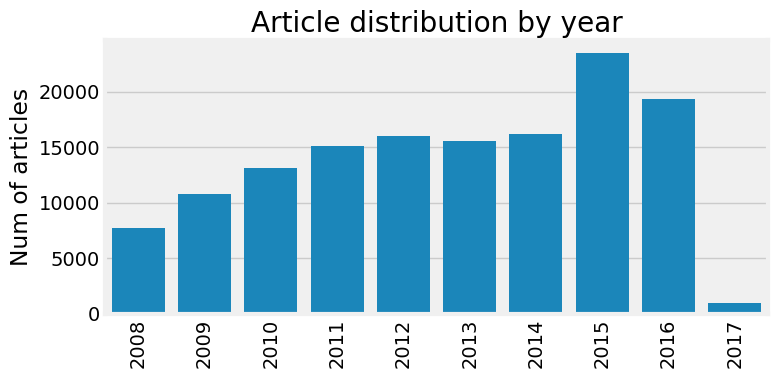

In [8]:
plt.figure(figsize = (8, 4))

plt.style.use('fivethirtyeight')
sns.countplot(x = 'year', data = habr_articles, order = habr_articles['year'].unique())
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Num of articles')
plt.title('Article distribution by year')
plt.tight_layout()
#plt.savefig('Article distribution.png', dpi = 600)

For this project, I will train my models using data from the 2015 time period and assess the quality using the 2016 test set. While the entire dataset is much larger, it may not be beneficial to consider data from too far back in the past when predicting future articles' ratings, as IT technology evolves rapidly. For example, information about popular articles from 2008 or 2012 is unlikely to be useful for predicting ratings in 2016.

To train a BERT model for generating text embeddings, I will utilize only a portion of the dataset due to constraints on GPU resources. However, even with this limited data, I expect to produce high-quality vector representations. 'svr_train' represents the subset of the dataset for which embeddings will be generated to train an SVR model.

In [9]:
bert_train = habr_articles[habr_articles['year'] == 2015].sample(n = 3000, random_state = 89)
svr_train = habr_articles[(habr_articles['year'] == 2015) & (~habr_articles['url'].isin(bert_train['url'].values))]
test = habr_articles[(habr_articles['year'] == 2016) & (habr_articles['month'] <= 4)]

In [10]:
bert_train.shape

(3000, 15)

In [11]:
bert_train.dropna(subset = ['content'], inplace = True)
bert_train.reset_index(drop = True, inplace = True)

In [12]:
bert_train.loc[500, 'content']

'Авраам Линкольн как-то сказал: « Дайте мне 6 часов, чтобы срубить дерево, и первые 4 часа я потрачу на заточку топора». В этой цитате прослеживается отличная аналогия с A/B тестированием. Если вы хотите сорвать куш при проведении A/B теста, то придётся очень хорошо подготовиться. И именно о том, как это нужно делать, вы узнаете в нашей статье.<br>\r\n<br>\r\n<img src="https://habrastorage.org/files/e17/a5d/cf8/e17a5dcf814d447ab9d35623b287be53.jpeg"><br>\r\n<br>\r\nМайкл Аагаард (один из самых известных экспертов в сфере оптимизации конверсии и копирайтинга), решил составить список самых серьёзных ошибок в A/B тестировании. Основываясь на своём многолетнем опыте, он пришёл к выводу, что его самая главная ошибка – проведение слишком большого количества экспериментов.<br>\r\n<br>\r\nЗвучит очень даже странно. На чём же тогда должен концентрироваться эксперт в <a href="http://boosta.ru/ab-testirovanie-what-is-it/">A/B тестировании</a>, если не на проведении экспериментов? Ответ внутри ста

In [13]:
bert_train.loc[1001, 'content']

'В этом материале я расскажу про любопытные мобильники для обеспечения безопасности детей и, как следствие, спокойствия родителей. Называются телефоны bb-mobile «GPS Маячок II» и bb-mobile «Светлячок». Стоит подчеркнуть, что помимо bb-mobile практически никто подобными аппаратами не занимается. Отдельные компании в разное время выпустили по одному-два подобных детских мобильника, и на том все и закончилось. Между тем bb-mobile упорно выпускает детские мобильники с функциями обеспечения безопасности с 2007 года. За это время создано более 10 моделей.<br>\r\n <br>\r\n<img src="https://habrastorage.org/getpro/geektimes/post_images/5ee/e27/e6b/5eee27e6bb2dddfa490a5516478394f8.jpg"><br>\r\n<a name="habracut"></a><br>\r\nСкажете, зачем такие трубки вообще нужны? Ну, очевидно, что дети у вас есть, хоть и не у всех. Нет – значит когда-то наверняка появятся. И вообще – все там будем, как говорится :-). Даже если у родителей айфоны, то давать такую технику ребёнку «садичного» и младшего школьног

In [14]:
bert_train.loc[777, 'content']

'<img src="https://habrastorage.org/getpro/geektimes/post_images/b2d/fd1/7eb/b2dfd17eb32e0beebe2978ba8fc3fa59.jpg" alt="image"><br>\r\n<br>\r\nЭмоциональная саморегуляция является важным компонентом психического здоровья человека, а неспособность в должной мере регулировать эмоций связана с психиатрическими расстройствами. Терапевты знают, какое влияние музыка имеет на эмоциональное состояние индивидуума, и могут использовать ее, чтобы помочь своим пациентам поднять настроение и даже облегчить симптомы психических расстройств, таких как депрессия. Но до сих пор неизвестно, как именно тот или иной музыкальный стиль влияет на психическое здоровье. <br>\r\n<br>\r\nУченые Центра междисциплинарных исследований музыки при Университете Ювяскюля, Аалто, университета Финляндии и Университета Орхус в Дании, решили выявить взаимосвязь между психическим здоровьем индивидуума и его музыкальными пристрастиями, исходя из поведенческих особенностей. Исследование было опубликовано в августе в журнале <

As you can see, the text data is contaminated with markup elements, links, etc., which need to be removed. I will use the following function for that purpose:

In [15]:
remove_links = re.compile(r'(https?|ftp):\/\/[^\s/$.?#].[^\s]*|habrahabr\.[^\s/$.?#].[^\s]*|www\.[^\s/$.?#].[^\s]*')

def clean_text_bert(html_text):

    soup = BeautifulSoup(html_text, 'html.parser')
    clean_text = soup.get_text(separator = ' ', strip = True)
    clean_text = remove_links.sub('', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    clean_text = re.sub(r'\s+([.,!?])', r'\1', clean_text)

    return clean_text

In [16]:
clean_text_bert(bert_train.loc[500, 'content'])

'Авраам Линкольн как-то сказал: « Дайте мне 6 часов, чтобы срубить дерево, и первые 4 часа я потрачу на заточку топора». В этой цитате прослеживается отличная аналогия с A/B тестированием. Если вы хотите сорвать куш при проведении A/B теста, то придётся очень хорошо подготовиться. И именно о том, как это нужно делать, вы узнаете в нашей статье. Майкл Аагаард (один из самых известных экспертов в сфере оптимизации конверсии и копирайтинга), решил составить список самых серьёзных ошибок в A/B тестировании. Основываясь на своём многолетнем опыте, он пришёл к выводу, что его самая главная ошибка – проведение слишком большого количества экспериментов. Звучит очень даже странно. На чём же тогда должен концентрироваться эксперт в A/B тестировании, если не на проведении экспериментов? Ответ внутри статьи. История одного успешного A/B теста Начнём с короткой истории. Работая над увеличением конверсии одного сайта, Майкл запустил эксперимент, в котором тестовый вариант посадочной страницы очень с

In [17]:
clean_text_bert(bert_train.loc[1001, 'content'])

'В этом материале я расскажу про любопытные мобильники для обеспечения безопасности детей и, как следствие, спокойствия родителей. Называются телефоны bb-mobile «GPS Маячок II» и bb-mobile «Светлячок». Стоит подчеркнуть, что помимо bb-mobile практически никто подобными аппаратами не занимается. Отдельные компании в разное время выпустили по одному-два подобных детских мобильника, и на том все и закончилось. Между тем bb-mobile упорно выпускает детские мобильники с функциями обеспечения безопасности с 2007 года. За это время создано более 10 моделей. Скажете, зачем такие трубки вообще нужны? Ну, очевидно, что дети у вас есть, хоть и не у всех. Нет – значит когда-то наверняка появятся. И вообще – все там будем, как говорится :-). Даже если у родителей айфоны, то давать такую технику ребёнку «садичного» и младшего школьного возраста по меньшей мере неразумно. Был личный опыт. 4-летний ребёнок посреди белого дня во время прогулки с двумя взрослыми вдруг расшалился, убежал и спрятался. И, е

In [18]:
clean_text_bert(bert_train.loc[777, 'content'])

'Эмоциональная саморегуляция является важным компонентом психического здоровья человека, а неспособность в должной мере регулировать эмоций связана с психиатрическими расстройствами. Терапевты знают, какое влияние музыка имеет на эмоциональное состояние индивидуума, и могут использовать ее, чтобы помочь своим пациентам поднять настроение и даже облегчить симптомы психических расстройств, таких как депрессия. Но до сих пор неизвестно, как именно тот или иной музыкальный стиль влияет на психическое здоровье. Ученые Центра междисциплинарных исследований музыки при Университете Ювяскюля, Аалто, университета Финляндии и Университета Орхус в Дании, решили выявить взаимосвязь между психическим здоровьем индивидуума и его музыкальными пристрастиями, исходя из поведенческих особенностей. Исследование было опубликовано в августе в журнале Frontiers in Human Neuroscience. «Некоторые способы борьбы с негативными эмоциями, обычно применяемые людьми, например, постоянные размышления о плохом, нанося

In [19]:
bert_train['clean_content'] = bert_train['content'].apply(clean_text_bert)

Let's calculate the lengths of the articles in our dataset.

In [20]:
def calc_len(text):
  return len(text.split(' '))

In [21]:
bert_train['clean_content_len'] = bert_train['clean_content'].apply(calc_len)

In [22]:
bert_train.shape

(2988, 17)

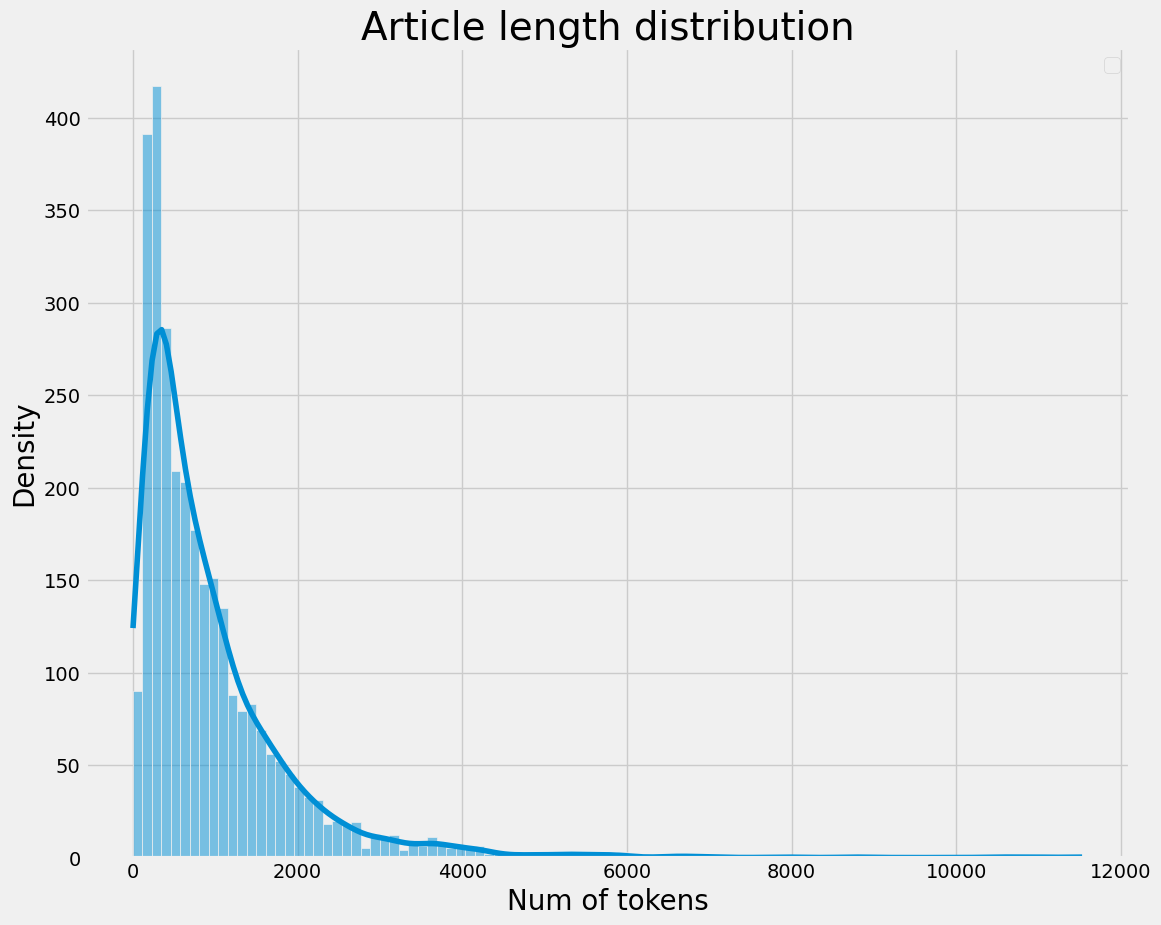

In [23]:
plt.figure(figsize = (12, 10))
sns.histplot(bert_train['clean_content_len'], bins = 100, kde = True)
plt.legend(loc = 'upper right', fontsize = 14)
plt.xlabel('Num of tokens', size = 20); plt.ylabel('Density', size = 20);
plt.title('Article length distribution', size = 28);

#plt.savefig('Article length distribtuion.png', dpi = 300)

We want to drop articles that are too short because otherwise masking a few tokens might remove a significant amount of context from the sentence

In [24]:
min_len = 30
perc = round(len(bert_train[bert_train['clean_content_len'] < min_len])/len(bert_train)*100, 2)
print(f'Percentage of articles with length less than {min_len}: {perc}')

Percentage of articles with length less than 30: 0.23


In [25]:
bert_train = bert_train[bert_train['clean_content_len'] >= min_len].reset_index(drop = True)

In [26]:
text = bert_train['clean_content'].tolist()

Tokenize the texts

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [28]:
inputs = tokenizer(text, max_length = 512, truncation = True, padding = 'max_length', return_tensors = 'pt')

Labels are the same as input_ids in MLM tasks.

In [29]:
inputs['labels'] = inputs.input_ids.clone()

In [30]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [31]:
inputs.input_ids[0]

tensor([   101,  20040,    522,  19097,  70619,  10433,    543,  26062,    557,
         50889,  67741,  10384,  96303,    558,  32321,  13518,  51382,  10113,
         12054,  13248,  16417,  72391,  10956,  46672,  23147,  97292,    558,
         58373,    543,  11431,  25334,  84515,  11050,  65424,    117,  81696,
         58742,  47990,  10970,  27796,  70619,  10993,  39452,  21297,    117,
           543,  13594, 106502, 103817,    543,  86968,  51599,  61381,  41794,
         18737,  34103,    119,    526,  18256,  34501,  11448,  13248,  16417,
        109295,  61381,  60623, 110409,  25334,    556,  30828,  49867,  10970,
         21297,    117,  12709,  59356,  10191,  33023, 108893,  10179,    549,
         21297,  10297,  11746,  97731,  64634,  43034,    119,  13518,  51382,
         10113,  12054,  46421,    543,  98757,    543,  10324,  10495,    549,
         45544,    543,  86968, 104121,  11075,  59781,  10241,  33930,  12559,
           119,    511,  85264,  69080, 

Now I will mask tokens in the input_ids tensor using a probability of 0.15, while excluding some specific tokens.

In [32]:
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [33]:
for i in range(inputs.input_ids.shape[0]):
    tokens_to_mask = torch.flatten(mask_arr[i].nonzero()).tolist()
    inputs.input_ids[i, tokens_to_mask] = 103

In [34]:
inputs.input_ids[0]

tensor([   101,  20040,    522,  19097,    103,  10433,    543,  26062,    557,
         50889,  67741,  10384,  96303,    558,  32321,  13518,  51382,  10113,
         12054,  13248,  16417,  72391,  10956,  46672,  23147,  97292,    558,
         58373,    103,    103,  25334,  84515,  11050,  65424,    103,  81696,
         58742,  47990,  10970,  27796,    103,  10993,  39452,  21297,    117,
           543,    103, 106502, 103817,    543,  86968,  51599,    103,  41794,
         18737,  34103,    119,    526,  18256,  34501,  11448,  13248,  16417,
           103,  61381,  60623, 110409,  25334,    556,  30828,  49867,  10970,
         21297,    117,  12709,  59356,    103,  33023, 108893,  10179,    549,
         21297,  10297,    103,  97731,    103,  43034,    119,  13518,  51382,
         10113,  12054,  46421,    543,  98757,    543,  10324,  10495,    549,
           103,    543,  86968, 104121,  11075,  59781,  10241,    103,  12559,
           119,    511,  85264,    103, 

Make a dataset and split it into train and validation subsets.

In [35]:
class HabrDataset(torch.utils.data.Dataset):
    def __init__(self, inputs):
        self.inputs = inputs
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.inputs.items()}
    def __len__(self):
        return len(self.inputs.input_ids)

In [36]:
dataset = HabrDataset(inputs)

In [37]:
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [38]:
train_iterator = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
validation_iterator = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = valid_sampler)

Build a LoRA model.

In [39]:
model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [41]:
model.bert.encoder.layer

ModuleList(
  (0-11): 12 x BertLayer(
    (attention): BertAttention(
      (self): BertSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [42]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

177974523

As you can see, the original MLM BERT model contains a significant number of parameters. Let's modify the BertSelfAttention layer by implementing a custom class to replace some of its modules. Credit: https://towardsdatascience.com/implementing-lora-from-scratch-20f838b046f1

In [43]:
class LoraBertSelfAttention(BertSelfAttention):

    """A module, which inherits from the standard BertSelfAttention, but initializes and adds LoRA matricies to it.

    We start by initializing query and value matricies needed for LoRA. The layers are named with the lora_ prefix so that they can be called easily.

    The forward method uses the new LoRA logic.

    r: LoRA matrix rank
    *args, **kwargs: original config and position_embedding_type from BertSelfAttention
    """

    def __init__(self, r = 8, *args, **kwargs):
        super().__init__(*args, **kwargs)
        d = self.all_head_size

        # Initialize trainable matrices A and B of dimensions d and r so that we can perform B*A. B is initialized with zeros, A with normally distributed random values
        self.lora_query_matrix_B = nn.Parameter(torch.zeros(d, r))
        self.lora_query_matrix_A = nn.Parameter(torch.randn(r, d))
        self.lora_value_matrix_B = nn.Parameter(torch.zeros(d, r))
        self.lora_value_matrix_A = nn.Parameter(torch.randn(r, d))


    def lora_query(self, x):
        lora_full_query_weights = torch.matmul(self.lora_query_matrix_B, self.lora_query_matrix_A)
        return self.query(x) + F.linear(x, lora_full_query_weights)


    def lora_value(self, x):
        lora_full_value_weights = torch.matmul(self.lora_value_matrix_B, self.lora_value_matrix_A)
        return self.value(x) + F.linear(x, lora_full_value_weights)


    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
            output_attentions: Optional[bool] = False,
        ) -> Tuple[torch.Tensor]:

        """Copied from https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py
        but replaced the original query and value calls with the lora_query and lora_value respectively.
        """

        mixed_query_layer = self.lora_query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.lora_value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.lora_value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.lora_value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [44]:
class LoraBertForMaskedLM(BertForMaskedLM):

  def __init__(self, config, lora_rank = 8, train_biases = True, train_embeddings = False, train_layer_norms = True):
    super().__init__(config)

    self.lora_rank = lora_rank
    self.train_biases = train_biases
    self.train_embeddings = train_embeddings
    self.train_layer_norms = train_layer_norms
    self.replace_multihead_attention()
    self.freeze_parameters_except_lora_and_bias()

  def replace_multihead_attention(self, verbose = True):

      self.nr_replaced_modules = 0
      self.replace_multihead_attention_recursion(self.bert)
      if verbose:
          print(f"Replaced {self.nr_replaced_modules} modules of BertSelfAttention with LoraBertSelfAttention")

  def replace_multihead_attention_recursion(self, model):

      for name, module in model.named_children():

          if isinstance(module, BertSelfAttention):
              self.nr_replaced_modules += 1

              # Create a new LoraMultiheadAttention layer
              new_layer = LoraBertSelfAttention(r = self.lora_rank, config = self.config)

              # Get the state of the original layer
              state_dict_old = module.state_dict()

              # Load the state dict to the new layer
              new_layer.load_state_dict(state_dict_old, strict = False)

              # Get the state of the new layer
              state_dict_new = new_layer.state_dict()

              # Compare keys of both state dicts
              keys_old = set(state_dict_old.keys())
              keys_new = set(k for k in state_dict_new.keys() if not k.startswith("lora_"))
              assert keys_old == keys_new, f"Keys of the state dictionaries don't match (ignoring lora parameters):\n\tExpected Parameters: {keys_old}\n\tNew Parameters (w.o. LoRA): {keys_new}"

              # Replace the original layer with the new layer
              setattr(model, name, new_layer)

          else:
              # Recurse on the child modules
              self.replace_multihead_attention_recursion(module)


  def freeze_parameters_except_lora_and_bias(self):
      """
      Freezes all parameters in the model, except those in LoRA layers and bias parameters, if specified.
      All lora parameters are identified by having a name that starts with *lora_*.
      """
      for name, param in self.bert.named_parameters():
          if ("lora_" in name) or (self.train_biases and "bias" in name) \
              or (self.train_embeddings and "embeddings" in name) or (self.train_layer_norms and "LayerNorm" in name):
              param.requires_grad = True
          else:
              param.requires_grad = False

In [45]:
lora_model = LoraBertForMaskedLM.from_pretrained('bert-base-multilingual-cased')

Replaced 12 modules of BertSelfAttention with LoraBertSelfAttention


Some weights of LoraBertForMaskedLM were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.attention.self.lora_query_matrix_A', 'bert.encoder.layer.0.attention.self.lora_query_matrix_B', 'bert.encoder.layer.0.attention.self.lora_value_matrix_A', 'bert.encoder.layer.0.attention.self.lora_value_matrix_B', 'bert.encoder.layer.1.attention.self.lora_query_matrix_A', 'bert.encoder.layer.1.attention.self.lora_query_matrix_B', 'bert.encoder.layer.1.attention.self.lora_value_matrix_A', 'bert.encoder.layer.1.attention.self.lora_value_matrix_B', 'bert.encoder.layer.10.attention.self.lora_query_matrix_A', 'bert.encoder.layer.10.attention.self.lora_query_matrix_B', 'bert.encoder.layer.10.attention.self.lora_value_matrix_A', 'bert.encoder.layer.10.attention.self.lora_value_matrix_B', 'bert.encoder.layer.11.attention.self.lora_query_matrix_A', 'bert.encoder.layer.11.attention.self.lora_query_matrix_B', 'bert.encoder.layer.11.at

In [46]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

1127931

I have drastically reduced the number of parameters, which should considerably accelerate the training process.

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lora_model.to(device)

LoraBertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): LoraBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [48]:
optim = torch.optim.AdamW(lora_model.parameters(), lr = 5e-5)

In [49]:
def train_bert(model, iterator, optimizer, device):

    epoch_loss = 0

    model.train()

    for batch in tqdm_iterator(iterator, desc = "Training"):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [50]:
def evaluate_bert(model, iterator, device):

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for batch in tqdm_iterator(iterator, desc = "Evaluating"):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs.loss

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in trange(EPOCHS, desc = "Epochs"):

    start_time = time.monotonic()

    train_loss = train_bert(lora_model, train_iterator, optim, device)
    valid_loss = evaluate_bert(lora_model, validation_iterator, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving new model')
        torch.save(lora_model, f'gdrive/MyDrive/ML/projects/habr_mlm_lora_model_e{epoch+1}.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Training:   0%|          | 0/597 [00:00<?, ?it/s]<ipython-input-37-c92f6d0014b5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.inputs.items()}
Evaluating: 100%|██████████| 149/149 [00:45<00:00,  3.30it/s]


Saving new model


Epochs:  10%|█         | 1/10 [07:05<1:03:52, 425.87s/it]


Epoch: 01 | Epoch Time: 7m 5s
	Train Loss: 0.336
	 Val. Loss: 0.218


Evaluating: 100%|██████████| 149/149 [00:44<00:00,  3.31it/s]


Saving new model


Epochs:  20%|██        | 2/10 [14:12<56:48, 426.03s/it]  


Epoch: 02 | Epoch Time: 7m 6s
	Train Loss: 0.246
	 Val. Loss: 0.214


Evaluating: 100%|██████████| 149/149 [00:45<00:00,  3.30it/s]


Saving new model


Epochs:  30%|███       | 3/10 [21:26<50:08, 429.78s/it]


Epoch: 03 | Epoch Time: 7m 14s
	Train Loss: 0.237
	 Val. Loss: 0.212


Evaluating: 100%|██████████| 149/149 [00:45<00:00,  3.31it/s]


Saving new model


Epochs:  40%|████      | 4/10 [28:32<42:50, 428.43s/it]


Epoch: 04 | Epoch Time: 7m 6s
	Train Loss: 0.229
	 Val. Loss: 0.212


Epochs:  50%|█████     | 5/10 [35:36<35:34, 426.89s/it]


Epoch: 05 | Epoch Time: 7m 4s
	Train Loss: 0.230
	 Val. Loss: 0.226


Evaluating: 100%|██████████| 149/149 [00:44<00:00,  3.32it/s]


Saving new model


Epochs:  60%|██████    | 6/10 [42:50<28:36, 429.20s/it]


Epoch: 06 | Epoch Time: 7m 13s
	Train Loss: 0.223
	 Val. Loss: 0.212


Evaluating: 100%|██████████| 149/149 [00:45<00:00,  3.30it/s]


Saving new model


Epochs:  70%|███████   | 7/10 [50:00<21:28, 429.34s/it]


Epoch: 07 | Epoch Time: 7m 9s
	Train Loss: 0.213
	 Val. Loss: 0.212


Evaluating: 100%|██████████| 149/149 [00:45<00:00,  3.30it/s]


Saving new model


Epochs:  80%|████████  | 8/10 [57:11<14:19, 429.89s/it]


Epoch: 08 | Epoch Time: 7m 11s
	Train Loss: 0.208
	 Val. Loss: 0.212


Epochs:  90%|█████████ | 9/10 [1:04:15<07:07, 428.00s/it]


Epoch: 09 | Epoch Time: 7m 3s
	Train Loss: 0.204
	 Val. Loss: 0.213


Epochs: 100%|██████████| 10/10 [1:11:17<00:00, 427.77s/it]


Epoch: 10 | Epoch Time: 7m 2s
	Train Loss: 0.201
	 Val. Loss: 0.214


In [52]:
def plot_loss(train_loss, valid_loss, save_im = False, save_name = 'Lora model loss plot.png', xticks_step = 1):
    fig, ax = plt.subplots()

    ax.plot(train_loss, label = 'Train loss')
    ax.plot(valid_loss, label = 'Valid loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Train vs Validation losses')
    ax.set_xticks(np.arange(0, len(train_loss), xticks_step))
    ax.set_xticklabels(np.arange(1, len(train_loss)+1, xticks_step))

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    if save_im:
      fig.savefig(save_name, dpi = 600)

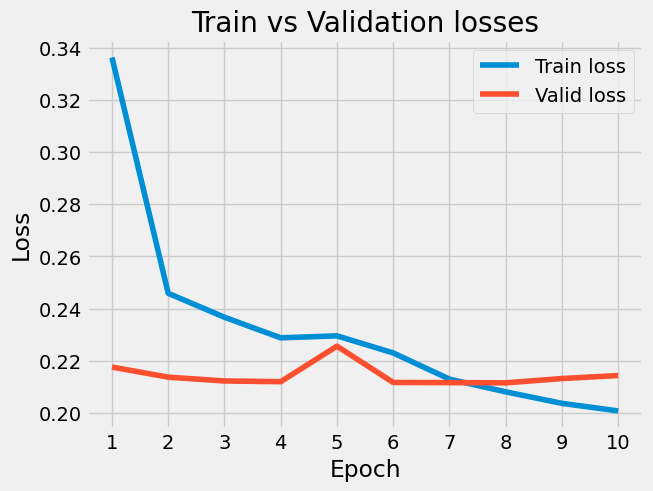

In [ ]:
plot_loss(train_losses, valid_losses, save_im = True)

In [53]:
lora_model = torch.load('gdrive/MyDrive/ML/projects/habr_mlm_lora_model_e7.pt')

In [54]:
def predict_masked_words(sentence):

  unmasker = pipeline('fill-mask', tokenizer = tokenizer, model = lora_model)
  filled_sentence = sentence
  for predictions in unmasker(sentence):
      prediction = predictions[0]
      filled_sentence = filled_sentence.replace('[MASK]', prediction['token_str'], 1)

  return filled_sentence

In [55]:
sentence = "Привет, Хабр! В [MASK] статьях мы касались ошибок и проблем с [MASK] Dell и HP, и наш рассказ об ошибках [MASK]-серверов был бы неполон без упоминания продукции третьего [MASK] «большой тройки» — [MASK]. Хотя эта славная [MASK] уже отошла от производства серверов, её [MASK] ещё активно используется. Поэтому спешим поделиться с вами опытом [MASK] IBM."
sentence

'Привет, Хабр! В [MASK] статьях мы касались ошибок и проблем с [MASK] Dell и HP, и наш рассказ об ошибках [MASK]-серверов был бы неполон без упоминания продукции третьего [MASK] «большой тройки» — [MASK]. Хотя эта славная [MASK] уже отошла от производства серверов, её [MASK] ещё активно используется. Поэтому спешим поделиться с вами опытом [MASK] IBM.'

In [56]:
predict_masked_words(sentence)

'Привет, Хабр! В этих статьях мы касались ошибок и проблем с участием Dell и HP, и наш рассказ об ошибках IT-серверов был бы неполон без упоминания продукции третьего поколения «большой тройки» — IBM. Хотя эта славная компания уже отошла от производства серверов, её сейчас ещё активно используется. Поэтому спешим поделиться с вами опытом в IBM.'

In [57]:
lora_model.to(device)

LoraBertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): LoraBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

I will now write a function for generating text embeddings for new sentences.

In [58]:
def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, max_length = 512, truncation = True, padding = 'max_length', return_tensors = 'pt')
    lora_model.eval()
    with torch.no_grad():
        outputs = lora_model.bert(**inputs.to(device))
    # Get the output embeddings from the last hidden bert layer
    sentence_embedding = torch.mean(outputs.last_hidden_state, dim = 1)  # Mean pooling of token embeddings
    return np.array([elem.item() for tensor in sentence_embedding for elem in tensor])

Again, I will take a portion of the svr_train subset to further speed up operations.

In [59]:
svr_train = svr_train.sample(n = 5000, random_state = 88)

In [60]:
svr_train.dropna(subset = ['content'], inplace = True)
svr_train.reset_index(drop = True, inplace = True)

In [61]:
tqdm.pandas()

In [62]:
svr_train['clean_content'] = svr_train['content'].apply(clean_text_bert)

In [63]:
svr_train['embeddings'] = svr_train['clean_content'].progress_apply(get_sentence_embedding)

100%|██████████| 4988/4988 [05:48<00:00, 14.30it/s]


In [ ]:
#svr_train.to_csv('gdrive/MyDrive/ML/projects/svr_train.csv', index = False)

In [64]:
X = np.array(svr_train['embeddings'].tolist())
y = svr_train['favs_lognorm']

In [65]:
def objective(trial):

    C = trial.suggest_float('C', 0.001, 10.0, log = True)
    gamma = trial.suggest_float('gamma', 0.005, 10.0, log = True)

    model = SVR(kernel = 'rbf', C = C, gamma = gamma)

    scores = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error')

    mse = -np.mean(scores)

    return mse

In [ ]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 20)

best_params = study.best_params
best_mse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)

[I 2024-04-12 15:12:39,806] A new study created in memory with name: no-name-8ac8f72b-563f-45d0-b22a-88b1d3ced571
[I 2024-04-12 15:13:13,068] Trial 0 finished with value: 1.0396042697765986 and parameters: {'C': 9.75473137519938, 'gamma': 3.25243492974836}. Best is trial 0 with value: 1.0396042697765986.
[I 2024-04-12 15:13:44,859] Trial 1 finished with value: 0.6088382221167014 and parameters: {'C': 0.9333744335325509, 'gamma': 0.00733105613025891}. Best is trial 1 with value: 0.6088382221167014.
[I 2024-04-12 15:14:16,242] Trial 2 finished with value: 1.0380337923900327 and parameters: {'C': 0.005381428236982649, 'gamma': 1.055755866980793}. Best is trial 1 with value: 0.6088382221167014.
[I 2024-04-12 15:14:50,077] Trial 3 finished with value: 1.0419727509965018 and parameters: {'C': 0.09273909575966369, 'gamma': 3.2224436659059803}. Best is trial 1 with value: 0.6088382221167014.
[I 2024-04-12 15:15:24,567] Trial 4 finished with value: 1.0413323766254614 and parameters: {'C': 0.440

Best Hyperparameters: {'C': 2.3199393728074496, 'gamma': 0.2730631928031543}
Best Mean Squared Error: 0.5500339822899116


In [66]:
svr_model = SVR(kernel = 'rbf', C = 2.3199393728074496, gamma = 0.2730631928031543)

In [67]:
svr_model.fit(X, y)

SVR(C=2.3199393728074496, gamma=0.2730631928031543)

In [68]:
def calc_regression_metrics(actual, predicted, df) -> dict:

    regression_metrics = {
    'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
    'Mean Squared Error': metrics.mean_squared_error(actual, predicted),
    'Mean Absolute Percentage Error': metrics.mean_absolute_percentage_error(actual, predicted)
    }

    metrics_df = pd.DataFrame.from_dict(regression_metrics, orient = 'index')
    metrics_df.columns = [df]

    return metrics_df

In [69]:
y_pred = svr_model.predict(X)

In [70]:
y_pred

array([ 0.47931423,  0.45508062,  0.53322741, ..., -1.68470983,
       -0.25328129,  0.98180724])

In [71]:
calc_regression_metrics(y, y_pred, 'SVM train')

,SVM train
Mean Absolute Error,0.120314
Mean Squared Error,0.032176
Mean Absolute Percentage Error,0.748257


In [72]:
test.dropna(subset = ['content'], inplace = True)
test.reset_index(drop = True, inplace = True)

<ipython-input-72-730900f91d53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(subset = ['content'], inplace = True)


In [73]:
test['clean_content'] = test['content'].apply(clean_text_bert)

<ipython-input-73-127d7674eb5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['clean_content'] = test['content'].apply(clean_text_bert)


In [74]:
tqdm.pandas()

In [75]:
test['embeddings'] = test['clean_content'].progress_apply(get_sentence_embedding)

100%|██████████| 7540/7540 [09:10<00:00, 13.71it/s]
<ipython-input-75-a79dc685d952>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['embeddings'] = test['clean_content'].progress_apply(get_sentence_embedding)


In [76]:
#test.to_csv('gdrive/MyDrive/ML/projects/svr_test.csv', index = False)

In [77]:
X_test = np.array(test['embeddings'].tolist())
y_test = test['favs_lognorm']

In [78]:
y_test_preds = svr_model.predict(X_test)

In [79]:
svm_test_metrics = calc_regression_metrics(y_test, y_test_preds, 'SVM test')

In [80]:
svm_test_metrics

,SVM test
Mean Absolute Error,0.585878
Mean Squared Error,0.563253
Mean Absolute Percentage Error,3.407713


Let's now train an LSTM model using data from the first 10 months of 2015 as the training set, and data from the last two months as the validation set, to prevent overfitting. We'll then estimate its performance against the LoRA BERT model on the same test set.

In [81]:
lstm_train = habr_articles[(habr_articles['year'] == 2015) & (habr_articles['month'] <= 10)].copy()
lstm_val = habr_articles[(habr_articles['year'] == 2015) & (habr_articles['month'] > 10)].copy()

In [82]:
lstm_train.dropna(subset = ['content'], inplace = True)
lstm_train.reset_index(drop = True, inplace = True)

lstm_val.dropna(subset = ['content'], inplace = True)
lstm_val.reset_index(drop = True, inplace = True)

I will create a separate text cleaning function as part of the LSTM preprocessing pipeline. Unlike BERT, this function will include the lemmatization of tokens.

In [83]:
remove_links = re.compile(r'(https?|ftp):\/\/[^\s/$.?#].[^\s]*|habrahabr\.[^\s/$.?#].[^\s]*|www\.[^\s/$.?#].[^\s]*')
bad_symbols = re.compile("[^а-яА-Яa-zA-Z]")
stop_words = set(stopwords.words("english")) | set(stopwords.words("russian"))

def clean_text_lstm(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator = ' ', strip = True)
    clean_text = remove_links.sub('', clean_text)
    clean_text = bad_symbols.sub(' ', clean_text)
    clean_text = clean_text.lower().split()
    clean_text = [lemmatize(word, lang = ('ru', 'en')) for word in clean_text if (word not in stop_words) and (len(lemmatize(word, lang = ('ru', 'en')))) > 3]
    return clean_text

In [84]:
tqdm.pandas()

In [85]:
lstm_train['clean_content'] = lstm_train['content'].progress_apply(clean_text_lstm)

100%|██████████| 19280/19280 [01:59<00:00, 160.82it/s]


In [86]:
lstm_val['clean_content'] = lstm_val['content'].progress_apply(clean_text_lstm)

100%|██████████| 4106/4106 [00:27<00:00, 148.37it/s]


In [87]:
def build_vocabulary(train_data, max_vocab_size):
    word_counts = {}
    for doc in train_data:
        for word in doc:
            word_counts[word] = word_counts.get(word, 0) + 1

    most_common_words = sorted(word_counts, key = word_counts.get, reverse = True)[:max_vocab_size]
    vocabulary = {word: idx + 1 for idx, word in enumerate(most_common_words)}
    return vocabulary

In [88]:
max_vocab_size = 15000

In [89]:
vocabulary = build_vocabulary(lstm_train['clean_content'], max_vocab_size)

In [90]:
def truncate_sentences(sentence, max_length):
    return sentence[:max_length]

In [91]:
max_seq_length = 512

In [92]:
tokenized_lstm_train = [[vocabulary.get(word, 0) for word in truncate_sentences(doc, max_seq_length)] for doc in lstm_train['clean_content']]
padded_lstm_train = [doc + [0]*(max_seq_length-len(doc)) for doc in tokenized_lstm_train]

In [93]:
tokenized_lstm_val = [[vocabulary.get(word, 0) for word in truncate_sentences(doc, max_seq_length)] for doc in lstm_val['clean_content']]
padded_lstm_val = [doc + [0]*(max_seq_length-len(doc)) for doc in tokenized_lstm_val]

In [94]:
BATCH_SIZE = 128

In [95]:
X_train = torch.LongTensor(padded_lstm_train)
y_train = torch.tensor(lstm_train['favs_lognorm'], dtype = torch.float)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

X_val = torch.LongTensor(padded_lstm_val)
y_val = torch.tensor(lstm_val['favs_lognorm'], dtype = torch.float)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [96]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, dropout = 0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 1, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [97]:
lstm_model = LSTMModel(input_dim = len(vocabulary) + 1, embedding_dim = 100, hidden_dim = 128, output_dim = 1, pad_idx = 0)

In [98]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.0001, weight_decay = 0.0001)

In [99]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lstm_model.to(device)

LSTMModel(
  (embedding): Embedding(15001, 100, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [100]:
def train_lstm(model, iterator, optimizer, device):

    epoch_loss = 0

    model.train()

    for batch in tqdm_iterator(iterator, desc = "Training"):

        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [101]:
def evaluate_lstm(model, iterator, device):

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for batch in tqdm_iterator(iterator, desc = "Evaluating"):

            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [102]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 100

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in trange(EPOCHS, desc = "Epochs"):

    start_time = time.monotonic()

    train_loss = train_lstm(lstm_model, train_loader, optimizer, device)
    valid_loss = evaluate_lstm(lstm_model, val_loader, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving new model')
        torch.save(lstm_model, f'gdrive/MyDrive/ML/projects/habr_lstm_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epochs:   1%|          | 1/100 [00:05<08:48,  5.34s/it]

Saving new model

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.974
	 Val. Loss: 0.945


Epochs:   2%|▏         | 2/100 [00:10<08:06,  4.97s/it]

Saving new model

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.857
	 Val. Loss: 0.883


Epochs:   3%|▎         | 3/100 [00:14<07:50,  4.85s/it]

Saving new model

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.804
	 Val. Loss: 0.839


Epochs:   4%|▍         | 4/100 [00:19<07:45,  4.84s/it]

Saving new model

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.785
	 Val. Loss: 0.836


Epochs:   5%|▌         | 5/100 [00:24<07:37,  4.81s/it]

Saving new model

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.764
	 Val. Loss: 0.828


Epochs:   6%|▌         | 6/100 [00:29<07:30,  4.79s/it]


Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.761
	 Val. Loss: 0.831


Epochs:   7%|▋         | 7/100 [00:34<07:29,  4.84s/it]

Saving new model

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.754
	 Val. Loss: 0.823


Epochs:   8%|▊         | 8/100 [00:38<07:24,  4.83s/it]

Saving new model

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.742
	 Val. Loss: 0.811


Epochs:   9%|▉         | 9/100 [00:43<07:22,  4.86s/it]

Saving new model

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.734
	 Val. Loss: 0.811


Epochs:  10%|█         | 10/100 [00:48<07:19,  4.88s/it]


Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.716
	 Val. Loss: 0.821


Epochs:  11%|█         | 11/100 [00:53<07:15,  4.89s/it]

Saving new model

Epoch: 11 | Epoch Time: 0m 4s
	Train Loss: 0.715
	 Val. Loss: 0.787


Epochs:  12%|█▏        | 12/100 [00:58<07:14,  4.94s/it]

Saving new model

Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.673
	 Val. Loss: 0.778


Epochs:  13%|█▎        | 13/100 [01:03<07:10,  4.95s/it]

Saving new model

Epoch: 13 | Epoch Time: 0m 4s
	Train Loss: 0.656
	 Val. Loss: 0.775


Epochs:  14%|█▍        | 14/100 [01:08<07:06,  4.96s/it]

Saving new model

Epoch: 14 | Epoch Time: 0m 4s
	Train Loss: 0.647
	 Val. Loss: 0.756


Epochs:  15%|█▌        | 15/100 [01:13<07:02,  4.97s/it]


Epoch: 15 | Epoch Time: 0m 4s
	Train Loss: 0.635
	 Val. Loss: 0.759


Epochs:  16%|█▌        | 16/100 [01:18<06:56,  4.96s/it]


Epoch: 16 | Epoch Time: 0m 4s
	Train Loss: 0.617
	 Val. Loss: 0.795


Epochs:  17%|█▋        | 17/100 [01:23<06:53,  4.99s/it]

Saving new model

Epoch: 17 | Epoch Time: 0m 5s
	Train Loss: 0.600
	 Val. Loss: 0.733


Epochs:  18%|█▊        | 18/100 [01:28<06:49,  4.99s/it]


Epoch: 18 | Epoch Time: 0m 4s
	Train Loss: 0.589
	 Val. Loss: 0.766


Epochs:  19%|█▉        | 19/100 [01:33<06:43,  4.98s/it]

Saving new model

Epoch: 19 | Epoch Time: 0m 4s
	Train Loss: 0.570
	 Val. Loss: 0.706


Epochs:  20%|██        | 20/100 [01:38<06:38,  4.98s/it]


Epoch: 20 | Epoch Time: 0m 4s
	Train Loss: 0.570
	 Val. Loss: 0.734


Epochs:  21%|██        | 21/100 [01:43<06:32,  4.97s/it]


Epoch: 21 | Epoch Time: 0m 4s
	Train Loss: 0.557
	 Val. Loss: 0.708


Epochs:  22%|██▏       | 22/100 [01:48<06:27,  4.97s/it]


Epoch: 22 | Epoch Time: 0m 4s
	Train Loss: 0.551
	 Val. Loss: 0.735


Epochs:  23%|██▎       | 23/100 [01:53<06:22,  4.97s/it]

Saving new model

Epoch: 23 | Epoch Time: 0m 4s
	Train Loss: 0.540
	 Val. Loss: 0.686


Epochs:  24%|██▍       | 24/100 [01:58<06:17,  4.97s/it]

Saving new model

Epoch: 24 | Epoch Time: 0m 4s
	Train Loss: 0.531
	 Val. Loss: 0.669


Epochs:  25%|██▌       | 25/100 [02:03<06:13,  4.99s/it]

Saving new model

Epoch: 25 | Epoch Time: 0m 5s
	Train Loss: 0.522
	 Val. Loss: 0.666


Epochs:  26%|██▌       | 26/100 [02:08<06:08,  4.98s/it]


Epoch: 26 | Epoch Time: 0m 4s
	Train Loss: 0.518
	 Val. Loss: 0.690


Epochs:  27%|██▋       | 27/100 [02:13<06:02,  4.97s/it]

Saving new model

Epoch: 27 | Epoch Time: 0m 4s
	Train Loss: 0.512
	 Val. Loss: 0.661


Epochs:  28%|██▊       | 28/100 [02:18<05:58,  4.98s/it]

Saving new model

Epoch: 28 | Epoch Time: 0m 4s
	Train Loss: 0.504
	 Val. Loss: 0.660


Epochs:  29%|██▉       | 29/100 [02:23<05:53,  4.97s/it]

Saving new model

Epoch: 29 | Epoch Time: 0m 4s
	Train Loss: 0.502
	 Val. Loss: 0.657


Epochs:  30%|███       | 30/100 [02:28<05:48,  4.98s/it]

Saving new model

Epoch: 30 | Epoch Time: 0m 4s
	Train Loss: 0.497
	 Val. Loss: 0.657


Epochs:  31%|███       | 31/100 [02:33<05:43,  4.98s/it]


Epoch: 31 | Epoch Time: 0m 4s
	Train Loss: 0.485
	 Val. Loss: 0.666


Epochs:  32%|███▏      | 32/100 [02:38<05:38,  4.97s/it]

Saving new model

Epoch: 32 | Epoch Time: 0m 4s
	Train Loss: 0.472
	 Val. Loss: 0.643


Epochs:  33%|███▎      | 33/100 [02:43<05:33,  4.98s/it]


Epoch: 33 | Epoch Time: 0m 4s
	Train Loss: 0.478
	 Val. Loss: 0.649


Epochs:  34%|███▍      | 34/100 [02:48<05:28,  4.97s/it]


Epoch: 34 | Epoch Time: 0m 4s
	Train Loss: 0.464
	 Val. Loss: 0.682


Epochs:  35%|███▌      | 35/100 [02:53<05:23,  4.97s/it]

Saving new model

Epoch: 35 | Epoch Time: 0m 4s
	Train Loss: 0.455
	 Val. Loss: 0.637


Epochs:  36%|███▌      | 36/100 [02:58<05:18,  4.97s/it]


Epoch: 36 | Epoch Time: 0m 4s
	Train Loss: 0.449
	 Val. Loss: 0.646


Epochs:  37%|███▋      | 37/100 [03:03<05:13,  4.97s/it]


Epoch: 37 | Epoch Time: 0m 4s
	Train Loss: 0.446
	 Val. Loss: 0.641


Epochs:  38%|███▊      | 38/100 [03:08<05:08,  4.97s/it]


Epoch: 38 | Epoch Time: 0m 4s
	Train Loss: 0.445
	 Val. Loss: 0.660


Epochs:  39%|███▉      | 39/100 [03:12<05:02,  4.97s/it]


Epoch: 39 | Epoch Time: 0m 4s
	Train Loss: 0.438
	 Val. Loss: 0.707


Epochs:  40%|████      | 40/100 [03:17<04:57,  4.97s/it]

Saving new model

Epoch: 40 | Epoch Time: 0m 4s
	Train Loss: 0.427
	 Val. Loss: 0.636


Epochs:  41%|████      | 41/100 [03:23<04:54,  4.99s/it]

Saving new model

Epoch: 41 | Epoch Time: 0m 5s
	Train Loss: 0.416
	 Val. Loss: 0.627


Epochs:  42%|████▏     | 42/100 [03:27<04:48,  4.97s/it]


Epoch: 42 | Epoch Time: 0m 4s
	Train Loss: 0.422
	 Val. Loss: 0.644


Epochs:  43%|████▎     | 43/100 [03:32<04:42,  4.96s/it]


Epoch: 43 | Epoch Time: 0m 4s
	Train Loss: 0.413
	 Val. Loss: 0.664


Epochs:  44%|████▍     | 44/100 [03:37<04:38,  4.97s/it]


Epoch: 44 | Epoch Time: 0m 4s
	Train Loss: 0.410
	 Val. Loss: 0.643


Epochs:  45%|████▌     | 45/100 [03:42<04:33,  4.96s/it]

Saving new model

Epoch: 45 | Epoch Time: 0m 4s
	Train Loss: 0.409
	 Val. Loss: 0.626


Epochs:  46%|████▌     | 46/100 [03:47<04:28,  4.97s/it]


Epoch: 46 | Epoch Time: 0m 4s
	Train Loss: 0.403
	 Val. Loss: 0.679


Epochs:  47%|████▋     | 47/100 [03:52<04:23,  4.96s/it]


Epoch: 47 | Epoch Time: 0m 4s
	Train Loss: 0.402
	 Val. Loss: 0.643


Epochs:  48%|████▊     | 48/100 [03:57<04:17,  4.96s/it]


Epoch: 48 | Epoch Time: 0m 4s
	Train Loss: 0.392
	 Val. Loss: 0.633


Epochs:  49%|████▉     | 49/100 [04:02<04:13,  4.98s/it]

Saving new model

Epoch: 49 | Epoch Time: 0m 5s
	Train Loss: 0.399
	 Val. Loss: 0.622


Epochs:  50%|█████     | 50/100 [04:07<04:08,  4.96s/it]


Epoch: 50 | Epoch Time: 0m 4s
	Train Loss: 0.383
	 Val. Loss: 0.623


Epochs:  51%|█████     | 51/100 [04:12<04:02,  4.96s/it]


Epoch: 51 | Epoch Time: 0m 4s
	Train Loss: 0.374
	 Val. Loss: 0.627


Epochs:  52%|█████▏    | 52/100 [04:17<03:57,  4.95s/it]


Epoch: 52 | Epoch Time: 0m 4s
	Train Loss: 0.380
	 Val. Loss: 0.622


Epochs:  53%|█████▎    | 53/100 [04:22<03:52,  4.95s/it]


Epoch: 53 | Epoch Time: 0m 4s
	Train Loss: 0.365
	 Val. Loss: 0.644


Epochs:  54%|█████▍    | 54/100 [04:27<03:47,  4.96s/it]


Epoch: 54 | Epoch Time: 0m 4s
	Train Loss: 0.360
	 Val. Loss: 0.643


Epochs:  55%|█████▌    | 55/100 [04:32<03:42,  4.95s/it]


Epoch: 55 | Epoch Time: 0m 4s
	Train Loss: 0.368
	 Val. Loss: 0.627


Epochs:  56%|█████▌    | 56/100 [04:37<03:37,  4.94s/it]


Epoch: 56 | Epoch Time: 0m 4s
	Train Loss: 0.360
	 Val. Loss: 0.651


Epochs:  57%|█████▋    | 57/100 [04:42<03:33,  4.95s/it]


Epoch: 57 | Epoch Time: 0m 4s
	Train Loss: 0.353
	 Val. Loss: 0.631


Epochs:  58%|█████▊    | 58/100 [04:47<03:27,  4.95s/it]


Epoch: 58 | Epoch Time: 0m 4s
	Train Loss: 0.346
	 Val. Loss: 0.632


Epochs:  59%|█████▉    | 59/100 [04:52<03:23,  4.95s/it]

Saving new model

Epoch: 59 | Epoch Time: 0m 4s
	Train Loss: 0.339
	 Val. Loss: 0.621


Epochs:  60%|██████    | 60/100 [04:57<03:17,  4.95s/it]


Epoch: 60 | Epoch Time: 0m 4s
	Train Loss: 0.346
	 Val. Loss: 0.624


Epochs:  61%|██████    | 61/100 [05:02<03:12,  4.94s/it]


Epoch: 61 | Epoch Time: 0m 4s
	Train Loss: 0.343
	 Val. Loss: 0.641


Epochs:  62%|██████▏   | 62/100 [05:07<03:08,  4.96s/it]


Epoch: 62 | Epoch Time: 0m 4s
	Train Loss: 0.330
	 Val. Loss: 0.658


Epochs:  63%|██████▎   | 63/100 [05:11<03:03,  4.95s/it]


Epoch: 63 | Epoch Time: 0m 4s
	Train Loss: 0.341
	 Val. Loss: 0.626


Epochs:  64%|██████▍   | 64/100 [05:16<02:58,  4.95s/it]


Epoch: 64 | Epoch Time: 0m 4s
	Train Loss: 0.319
	 Val. Loss: 0.684


Epochs:  65%|██████▌   | 65/100 [05:21<02:53,  4.97s/it]


Epoch: 65 | Epoch Time: 0m 4s
	Train Loss: 0.323
	 Val. Loss: 0.632


Epochs:  66%|██████▌   | 66/100 [05:26<02:48,  4.96s/it]


Epoch: 66 | Epoch Time: 0m 4s
	Train Loss: 0.320
	 Val. Loss: 0.630


Epochs:  67%|██████▋   | 67/100 [05:31<02:43,  4.95s/it]


Epoch: 67 | Epoch Time: 0m 4s
	Train Loss: 0.314
	 Val. Loss: 0.640


Epochs:  68%|██████▊   | 68/100 [05:36<02:38,  4.96s/it]


Epoch: 68 | Epoch Time: 0m 4s
	Train Loss: 0.307
	 Val. Loss: 0.648


Epochs:  69%|██████▉   | 69/100 [05:41<02:33,  4.95s/it]


Epoch: 69 | Epoch Time: 0m 4s
	Train Loss: 0.316
	 Val. Loss: 0.631


Epochs:  70%|███████   | 70/100 [05:46<02:28,  4.96s/it]


Epoch: 70 | Epoch Time: 0m 4s
	Train Loss: 0.302
	 Val. Loss: 0.624


Epochs:  71%|███████   | 71/100 [05:51<02:23,  4.96s/it]

Saving new model

Epoch: 71 | Epoch Time: 0m 4s
	Train Loss: 0.294
	 Val. Loss: 0.619


Epochs:  72%|███████▏  | 72/100 [05:56<02:18,  4.95s/it]


Epoch: 72 | Epoch Time: 0m 4s
	Train Loss: 0.298
	 Val. Loss: 0.633


Epochs:  73%|███████▎  | 73/100 [06:01<02:13,  4.96s/it]


Epoch: 73 | Epoch Time: 0m 4s
	Train Loss: 0.289
	 Val. Loss: 0.712


Epochs:  74%|███████▍  | 74/100 [06:06<02:08,  4.96s/it]


Epoch: 74 | Epoch Time: 0m 4s
	Train Loss: 0.285
	 Val. Loss: 0.628


Epochs:  75%|███████▌  | 75/100 [06:11<02:03,  4.95s/it]


Epoch: 75 | Epoch Time: 0m 4s
	Train Loss: 0.289
	 Val. Loss: 0.626


Epochs:  76%|███████▌  | 76/100 [06:16<01:58,  4.96s/it]


Epoch: 76 | Epoch Time: 0m 4s
	Train Loss: 0.284
	 Val. Loss: 0.715


Epochs:  77%|███████▋  | 77/100 [06:21<01:53,  4.95s/it]


Epoch: 77 | Epoch Time: 0m 4s
	Train Loss: 0.279
	 Val. Loss: 0.655


Epochs:  78%|███████▊  | 78/100 [06:26<01:49,  4.96s/it]


Epoch: 78 | Epoch Time: 0m 4s
	Train Loss: 0.274
	 Val. Loss: 0.673


Epochs:  79%|███████▉  | 79/100 [06:31<01:43,  4.95s/it]


Epoch: 79 | Epoch Time: 0m 4s
	Train Loss: 0.270
	 Val. Loss: 0.621


Epochs:  80%|████████  | 80/100 [06:36<01:38,  4.94s/it]


Epoch: 80 | Epoch Time: 0m 4s
	Train Loss: 0.264
	 Val. Loss: 0.647


Epochs:  81%|████████  | 81/100 [06:41<01:34,  4.96s/it]


Epoch: 81 | Epoch Time: 0m 4s
	Train Loss: 0.272
	 Val. Loss: 0.637


Epochs:  82%|████████▏ | 82/100 [06:46<01:29,  4.95s/it]


Epoch: 82 | Epoch Time: 0m 4s
	Train Loss: 0.267
	 Val. Loss: 0.686


Epochs:  83%|████████▎ | 83/100 [06:51<01:24,  4.95s/it]


Epoch: 83 | Epoch Time: 0m 4s
	Train Loss: 0.254
	 Val. Loss: 0.664


Epochs:  84%|████████▍ | 84/100 [06:56<01:19,  4.95s/it]


Epoch: 84 | Epoch Time: 0m 4s
	Train Loss: 0.268
	 Val. Loss: 0.655


Epochs:  85%|████████▌ | 85/100 [07:00<01:14,  4.94s/it]


Epoch: 85 | Epoch Time: 0m 4s
	Train Loss: 0.248
	 Val. Loss: 0.634


Epochs:  86%|████████▌ | 86/100 [07:05<01:09,  4.95s/it]


Epoch: 86 | Epoch Time: 0m 4s
	Train Loss: 0.248
	 Val. Loss: 0.662


Epochs:  87%|████████▋ | 87/100 [07:10<01:04,  4.94s/it]


Epoch: 87 | Epoch Time: 0m 4s
	Train Loss: 0.249
	 Val. Loss: 0.676


Epochs:  88%|████████▊ | 88/100 [07:15<00:59,  4.94s/it]


Epoch: 88 | Epoch Time: 0m 4s
	Train Loss: 0.247
	 Val. Loss: 0.700


Epochs:  89%|████████▉ | 89/100 [07:20<00:54,  4.96s/it]


Epoch: 89 | Epoch Time: 0m 4s
	Train Loss: 0.248
	 Val. Loss: 0.664


Epochs:  90%|█████████ | 90/100 [07:25<00:49,  4.96s/it]


Epoch: 90 | Epoch Time: 0m 4s
	Train Loss: 0.236
	 Val. Loss: 0.648


Epochs:  91%|█████████ | 91/100 [07:30<00:44,  4.95s/it]


Epoch: 91 | Epoch Time: 0m 4s
	Train Loss: 0.230
	 Val. Loss: 0.641


Epochs:  92%|█████████▏| 92/100 [07:35<00:39,  4.95s/it]


Epoch: 92 | Epoch Time: 0m 4s
	Train Loss: 0.230
	 Val. Loss: 0.748


Epochs:  93%|█████████▎| 93/100 [07:40<00:34,  4.94s/it]


Epoch: 93 | Epoch Time: 0m 4s
	Train Loss: 0.227
	 Val. Loss: 0.669


Epochs:  94%|█████████▍| 94/100 [07:45<00:29,  4.96s/it]


Epoch: 94 | Epoch Time: 0m 4s
	Train Loss: 0.220
	 Val. Loss: 0.709


Epochs:  95%|█████████▌| 95/100 [07:50<00:24,  4.96s/it]


Epoch: 95 | Epoch Time: 0m 4s
	Train Loss: 0.221
	 Val. Loss: 0.658


Epochs:  96%|█████████▌| 96/100 [07:55<00:19,  4.95s/it]


Epoch: 96 | Epoch Time: 0m 4s
	Train Loss: 0.219
	 Val. Loss: 0.704


Epochs:  97%|█████████▋| 97/100 [08:00<00:14,  4.96s/it]


Epoch: 97 | Epoch Time: 0m 4s
	Train Loss: 0.217
	 Val. Loss: 0.702


Epochs:  98%|█████████▊| 98/100 [08:05<00:09,  4.95s/it]


Epoch: 98 | Epoch Time: 0m 4s
	Train Loss: 0.220
	 Val. Loss: 0.682


Epochs:  99%|█████████▉| 99/100 [08:10<00:04,  4.94s/it]


Epoch: 99 | Epoch Time: 0m 4s
	Train Loss: 0.218
	 Val. Loss: 0.698


Epochs: 100%|██████████| 100/100 [08:15<00:00,  4.95s/it]


Epoch: 100 | Epoch Time: 0m 4s
	Train Loss: 0.217
	 Val. Loss: 0.701


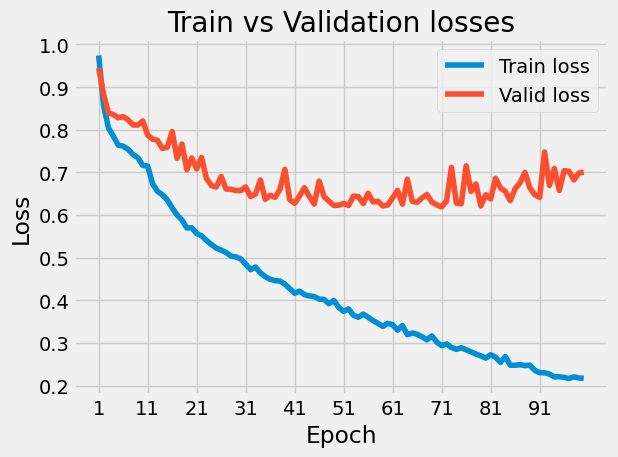

In [ ]:
plot_loss(train_losses, valid_losses, save_im = True, save_name = 'Lstm model loss plot.png', xticks_step = 10)

In [103]:
lstm_test = habr_articles[(habr_articles['year'] == 2016) & (habr_articles['month'] <= 4)]
lstm_test.dropna(subset = ['content'], inplace = True)
lstm_test.reset_index(drop = True, inplace = True)

<ipython-input-103-77c403e910ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_test.dropna(subset = ['content'], inplace = True)


In [104]:
lstm_test['clean_content'] = lstm_test['content'].progress_apply(clean_text_lstm)

100%|██████████| 7540/7540 [00:51<00:00, 146.99it/s]
<ipython-input-104-ef6339ab9c7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_test['clean_content'] = lstm_test['content'].progress_apply(clean_text_lstm)


In [105]:
tokenized_lstm_test = [[vocabulary.get(word, 0) for word in truncate_sentences(doc, max_seq_length)] for doc in lstm_test['clean_content']]
padded_lstm_test = [doc + [0]*(max_seq_length-len(doc)) for doc in tokenized_lstm_test]

In [106]:
X_test = torch.LongTensor(padded_lstm_test)
y_test = torch.tensor(lstm_test['favs_lognorm'], dtype = torch.float)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

In [107]:
lstm_model = torch.load('gdrive/MyDrive/ML/projects/habr_lstm_model.pt')

In [108]:
lstm_model.to(device)

LSTMModel(
  (embedding): Embedding(15001, 100, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [109]:
test_labels = []
test_preds = []

lstm_model.eval()

with torch.no_grad():

  for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = lstm_model(inputs).squeeze()

    test_labels.extend(labels.cpu().numpy())
    test_preds.extend(outputs.cpu().numpy())

In [110]:
len(test_labels) == len(test_preds)

True

In [111]:
lstm_test_metrics = calc_regression_metrics(np.array(test_labels), np.array(test_preds), 'LSTM test')

We can clearly see that the performance of the LSTM model is inferior to that of BERT, even though the latter was trained on a much smaller subset of data.

In [112]:
lstm_test_metrics

,LSTM test
Mean Absolute Error,0.602865
Mean Squared Error,0.592548
Mean Absolute Percentage Error,3.723481


In [113]:
svm_test_metrics

,SVM test
Mean Absolute Error,0.585878
Mean Squared Error,0.563253
Mean Absolute Percentage Error,3.407713


Let's now perform additional feature engineering to produce more features to be used along with BERT embeddings when training an SVR model, and see if we can further improve the performance of the model on the test set.

In [114]:
svr_train = pd.read_csv('gdrive/MyDrive/ML/projects/svr_train.csv')

In [115]:
svr_train

,url,domain,published,author,flow,polling,content_len,title,favs_lognorm,dataset,hub_title,tags,content,year,month,clean_content,embeddings
0,https://habrahabr.ru/post/272869/,habrahabr.ru,2015-12-11 11:59:00,@AlexGluck,admin,False,42610,"О том, как я неделю вдуплял в Bareos",1.082698,train,Системное администрирование,"['bareos', '*nix', 'backup']",Попала ко мне задача организовать резервное ко...,2015,12,Попала ко мне задача организовать резервное ко...,[-4.91865259e-03 -5.00336766e-01 3.65570068e-...
1,https://habrahabr.ru/post/269737/,habrahabr.ru,2015-11-12 21:38:00,@ru_crypt,develop,False,22135,"Безопасное криптопрограммирование. Часть 2, за...",1.097419,train,Программирование,"['перевод', 'криптография', 'программирование']",Продолжаем перевод набора правил безопасного к...,2015,11,Продолжаем перевод набора правил безопасного к...,[-9.90969613e-02 -4.56983715e-01 3.26779842e-...
2,https://habrahabr.ru/company/ringcloud/blog/28...,habrahabr.ru,2015-04-17 10:42:00,NaN,marketing,False,4240,Теперь я владелец интернет-магазина (Часть 2),-0.053988,train,Блог компании RingCloud,"['интернет магазин', 'виртуальная атс', 'телеф...","<img src=""https://habrastorage.org/files/fa4/9...",2015,4,Виртуальная АТС RingCloud продолжает рассказыв...,[-8.83729458e-02 -2.88081855e-01 6.26416624e-...
3,https://habrahabr.ru/company/hpe/blog/252717/,habrahabr.ru,2015-03-11 10:19:00,NaN,misc,False,10604,Гиперконвергентные платформы HP для виртуализации,-0.595046,train,Блог компании Hewlett Packard Enterprise,"['hp', 'convergedsystems', 'virtualization', '...",Все чаще со стороны заказчика встречаются треб...,2015,3,Все чаще со стороны заказчика встречаются треб...,[-1.06141768e-01 -2.02677161e-01 6.07810676e-...
4,https://habrahabr.ru/company/mailru/blog/271179/,habrahabr.ru,2015-11-19 15:52:00,NaN,develop,False,5921,Итоги Russian Developers Cup 2015,-0.307942,train,Программирование,"['mail.ru', 'russian developers cup']","<div style=""text-align:center;""><img src=""http...",2015,11,14 ноября состоялся финал третьего международн...,[-7.34752715e-02 -3.58795702e-01 5.06355107e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4979,https://geektimes.ru/post/248694/,geektimes.ru,2015-04-08 11:36:00,@marks,NaN,False,1808,"Анбоксинг посылки с МКС: инструменты и детали,...",-2.844387,train,Научно-популярное,"['3d принтеры', 'мкс']","<img src=""https://habrastorage.org/getpro/geek...",2015,4,Каждые несколько месяцев с Земли на МКС отправ...,[ 0.01233855 -0.24984914 0.65540397 0.074567...
4980,https://habrahabr.ru/company/bonjoin/blog/297266/,habrahabr.ru,2015-12-14 13:48:00,NaN,management,False,11276,Bonjoin: как мы соединяем желания одних и умен...,-1.874760,train,Блог компании БонДжойн,"['b2b', 'услуги', 'управление персоналом', 'аг...","<a href=""http://megamozg.ru/company/bonjoin/bl...",2015,12,"Наверное, уже не все помнят, когда появилась э...",[-7.25185424e-02 -3.41519415e-01 6.04162037e-...
4981,https://habrahabr.ru/company/masterkit/blog/25...,habrahabr.ru,2015-04-20 13:10:00,NaN,misc,False,14010,Как собрать робота своими руками за 6 часов и ...,0.986935,train,Блог компании МАСТЕР КИТ,"['электроника', 'DIY', 'роботы']","Сейчас уже мало кто помнит, к сожалению, что в...",2015,4,"Сейчас уже мало кто помнит, к сожалению, что в...",[ 1.77597906e-02 -2.95889407e-01 4.12129611e-...
4982,https://geektimes.ru/company/ulmart/blog/252456/,geektimes.ru,2015-07-09 18:43:00,NaN,NaN,False,10131,Видеозахват на все случаи жизни,1.148436,train,Потоковое видео,"['захват видео', 'tv-тюнер', 'fraps', 'bandica...","Привет, Geektimes. Сегодня поговорим о достато...",2015,7,"Привет, Geektimes. Сегодня поговорим о достато...",[-4.10144627e-02 -3.22240323e-01 5.86956978e-...


In [116]:
svr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            4984 non-null   object 
 1   domain         4984 non-null   object 
 2   published      4984 non-null   object 
 3   author         3144 non-null   object 
 4   flow           3172 non-null   object 
 5   polling        4984 non-null   bool   
 6   content_len    4984 non-null   int64  
 7   title          4984 non-null   object 
 8   favs_lognorm   4984 non-null   float64
 9   dataset        4984 non-null   object 
 10  hub_title      4984 non-null   object 
 11  tags           4984 non-null   object 
 12  content        4984 non-null   object 
 13  year           4984 non-null   int64  
 14  month          4984 non-null   int64  
 15  clean_content  4983 non-null   object 
 16  embeddings     4984 non-null   object 
dtypes: bool(1), float64(1), int64(3), object(12)
memory 

Below are multiple visualizations that should help to identify potentially useful features.

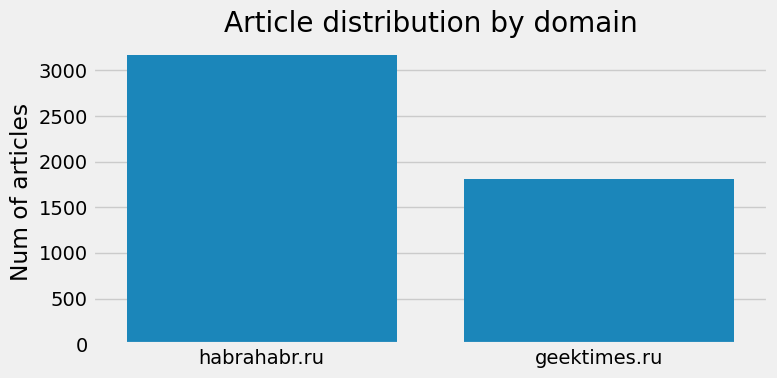

In [117]:
plt.figure(figsize = (8, 4))

plt.style.use('fivethirtyeight')
sns.countplot(x = 'domain', data = svr_train)
plt.xlabel('')
plt.ylabel('Num of articles')
plt.title('Article distribution by domain')
plt.tight_layout()
#plt.savefig('Article distribution by domain.png', dpi = 300)

<ipython-input-118-949a6c9018b0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "domain", y = "favs_lognorm", data = svr_train, palette = "coolwarm")


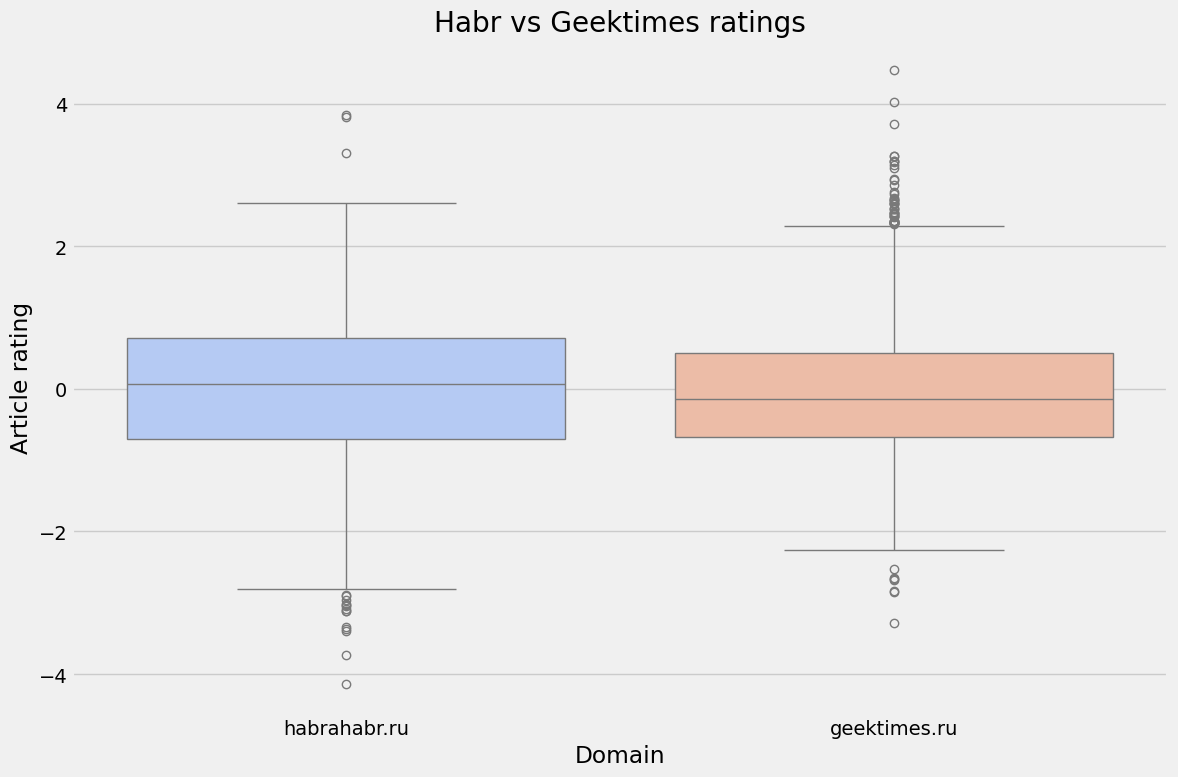

In [118]:
plt.figure(figsize = (12, 8))
sns.boxplot(x = "domain", y = "favs_lognorm", data = svr_train, palette = "coolwarm")
plt.title("Habr vs Geektimes ratings")
plt.xlabel('Domain')
plt.ylabel("Article rating")
plt.tight_layout()
#plt.savefig('Habr vs Geektimes ratings.png', dpi = 300)

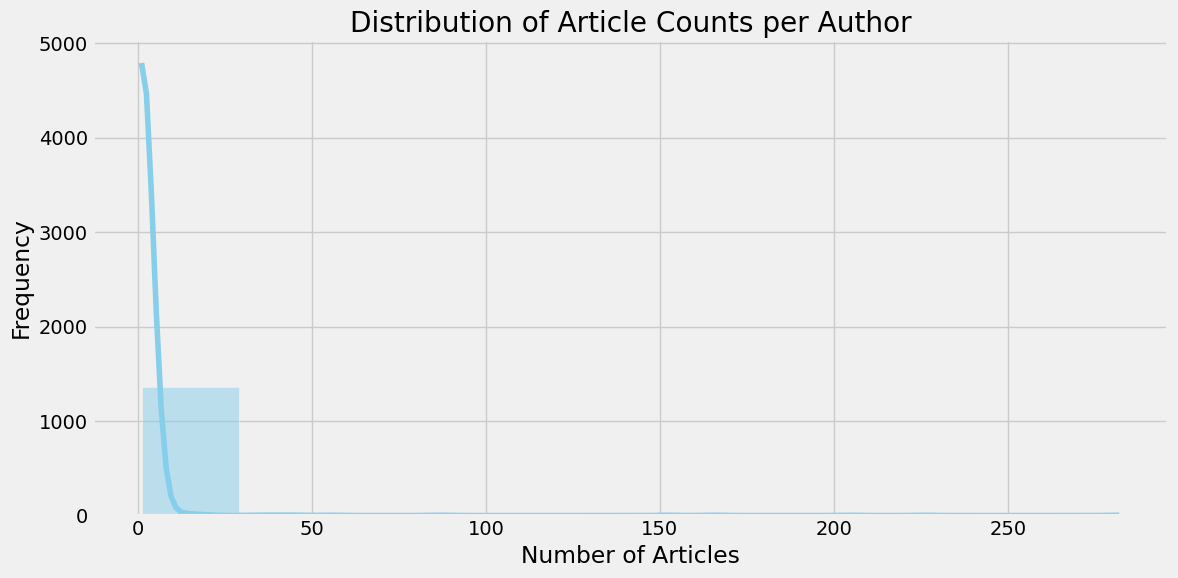

In [119]:
author_counts = svr_train['author'].value_counts()

plt.figure(figsize = (12, 6))
sns.histplot(author_counts, bins = 10, kde = True, color = 'skyblue')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Article Counts per Author')
plt.tight_layout()
#plt.savefig('Distribution of Article Counts per Author.png', dpi = 300)

In [120]:
threshold = 0.02
top_authors = author_counts[author_counts / len(svr_train) > threshold]

In [121]:
top_authors

author
@marks               282
@SLY_G               225
@ivansychev          204
@alizar              166
@semen_grinshtein    152
Name: count, dtype: int64

In [122]:
svr_train['top_authors'] = svr_train['author']
svr_train.loc[~svr_train['top_authors'].isin(top_authors.index.tolist()), 'top_authors'] = 'Other'

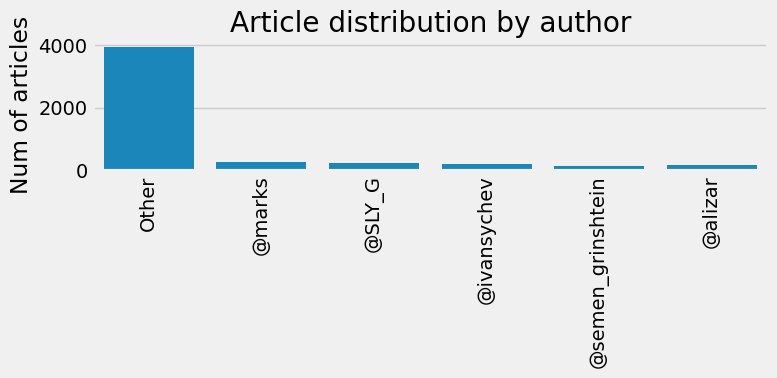

In [123]:
plt.figure(figsize = (8, 4))

plt.style.use('fivethirtyeight')
sns.countplot(x = 'top_authors', data = svr_train)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Num of articles')
plt.title('Article distribution by author')
plt.tight_layout()
#plt.savefig('Article distribution by author.png', dpi = 300)

<ipython-input-124-f51a04509adc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = "top_authors", y = "favs_lognorm", data = svr_train, palette = "Set2")


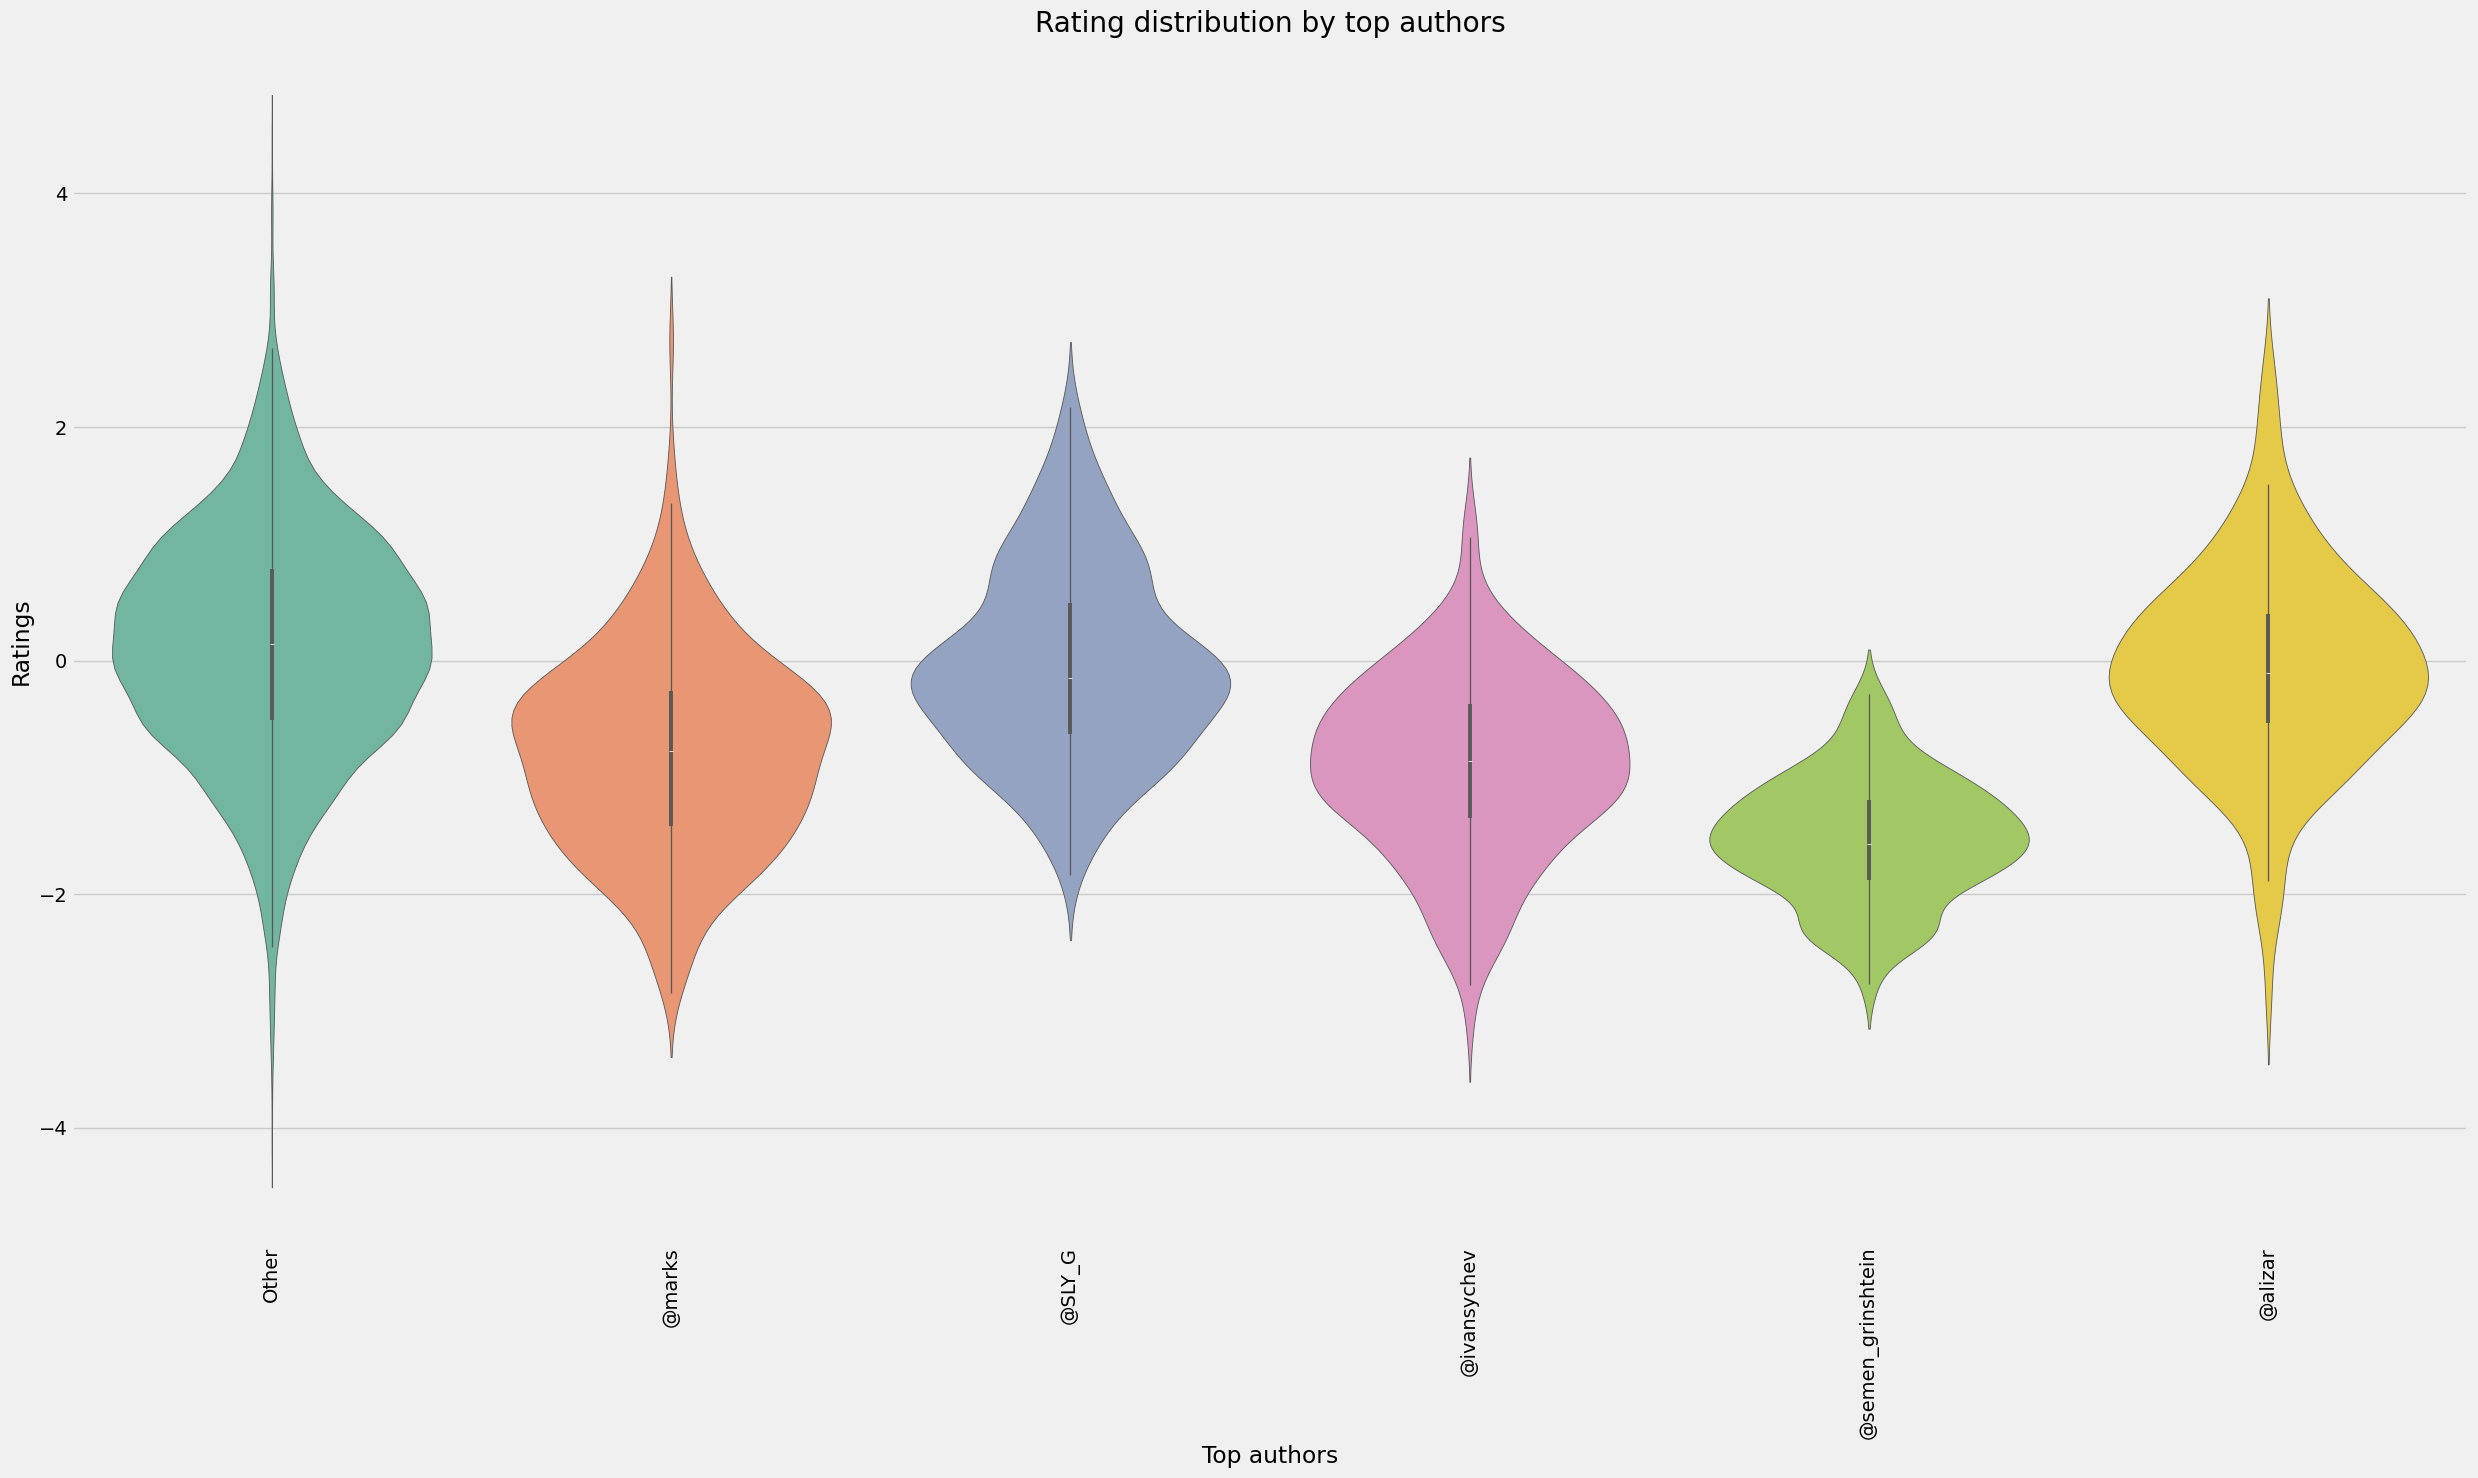

In [124]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.violinplot(x = "top_authors", y = "favs_lognorm", data = svr_train, palette = "Set2")
plt.title("Rating distribution by top authors")
plt.xticks(rotation = 90)
plt.xlabel("Top authors")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating distribution by top authors.png', dpi = 300)

In [125]:
svr_train['flow'].fillna('Not specified', inplace = True)

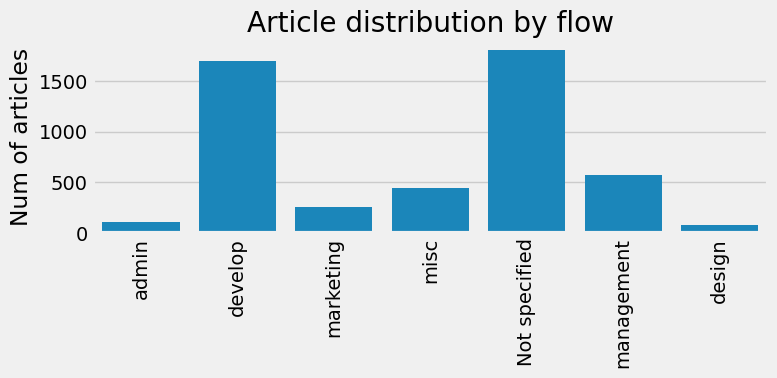

In [126]:
plt.figure(figsize = (8, 4))

plt.style.use('fivethirtyeight')
sns.countplot(x = 'flow', data = svr_train)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Num of articles')
plt.title('Article distribution by flow')
plt.tight_layout()
#plt.savefig('Article distribution by flow.png', dpi = 300)

<ipython-input-127-cf13c286efb2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = "flow", y = "favs_lognorm", data = svr_train, palette = "Set2")


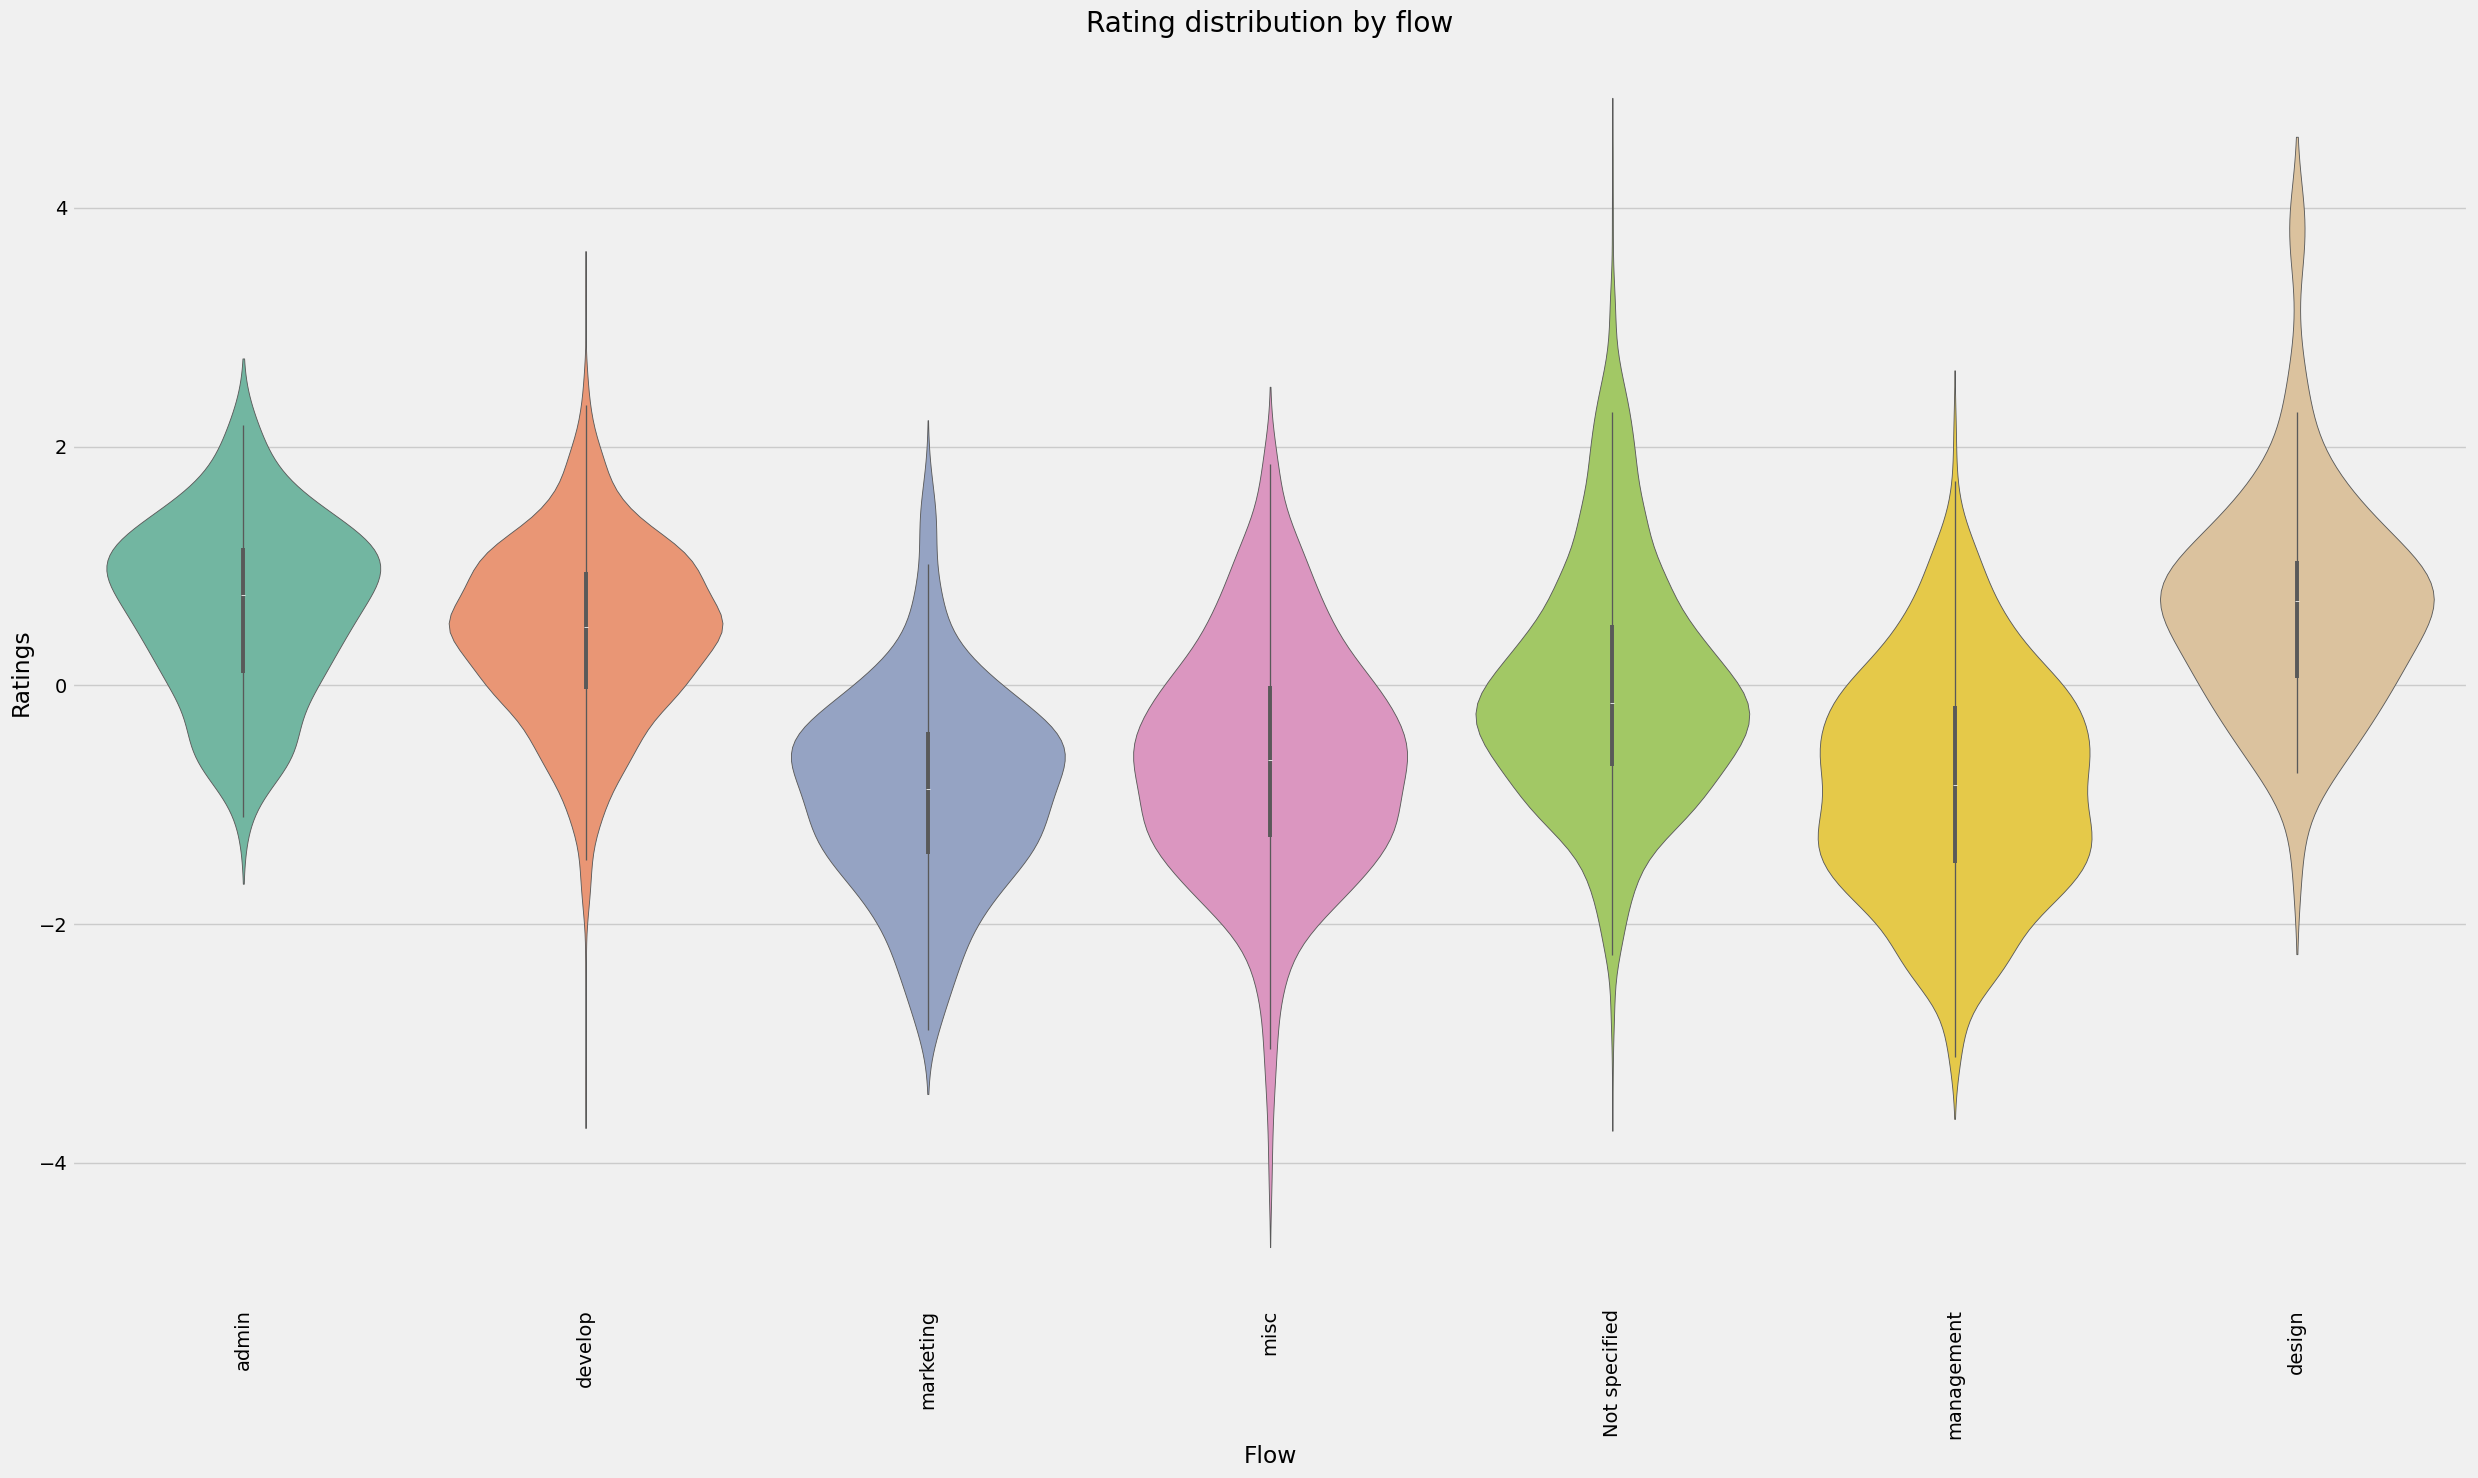

In [127]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.violinplot(x = "flow", y = "favs_lognorm", data = svr_train, palette = "Set2")
plt.title("Rating distribution by flow")
plt.xticks(rotation = 90)
plt.xlabel("Flow")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating distribution by flow.png', dpi = 300)

In [128]:
hub_counts = svr_train['hub_title'].value_counts()
threshold = 0.02
top_hubs = hub_counts[hub_counts / len(svr_train) > threshold]

In [129]:
top_hubs

hub_title
Разработка веб-сайтов          256
Научно-популярное              193
Программирование               179
Информационная безопасность    154
IT-компании                    146
Name: count, dtype: int64

In [130]:
svr_train['top_hubs'] = svr_train['hub_title']
svr_train.loc[~svr_train['top_hubs'].isin(top_hubs.index.tolist()), 'top_hubs'] = 'Other'

<ipython-input-131-e01601e0c2c7>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


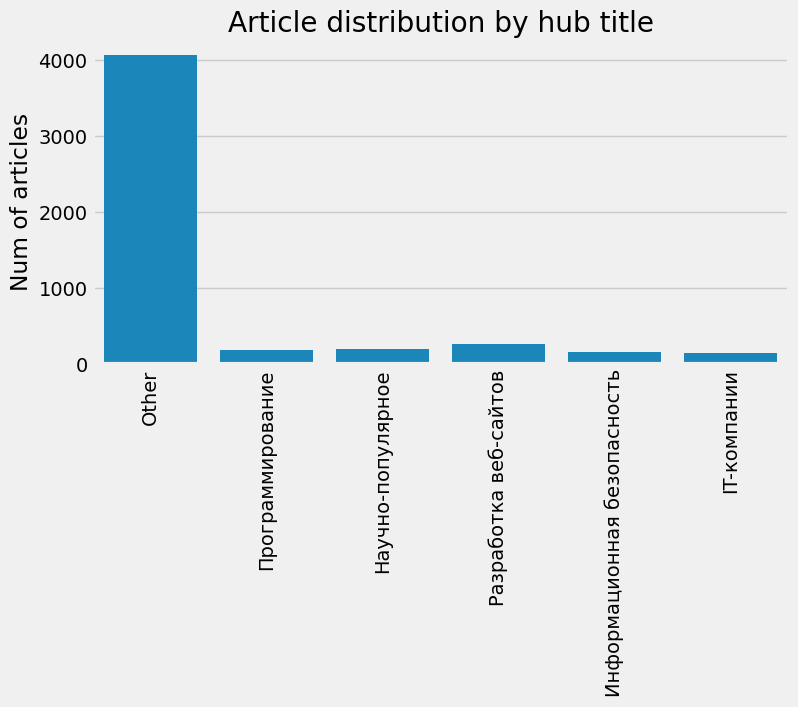

In [131]:
plt.figure(figsize = (8, 4))

plt.style.use('fivethirtyeight')
sns.countplot(x = 'top_hubs', data = svr_train)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Num of articles')
plt.title('Article distribution by hub title')
plt.tight_layout()
#plt.savefig('Article distribution by hub title.png', dpi = 300)

<ipython-input-132-14ee99fc4c2a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = "top_hubs", y = "favs_lognorm", data = svr_train, palette = "Set2")


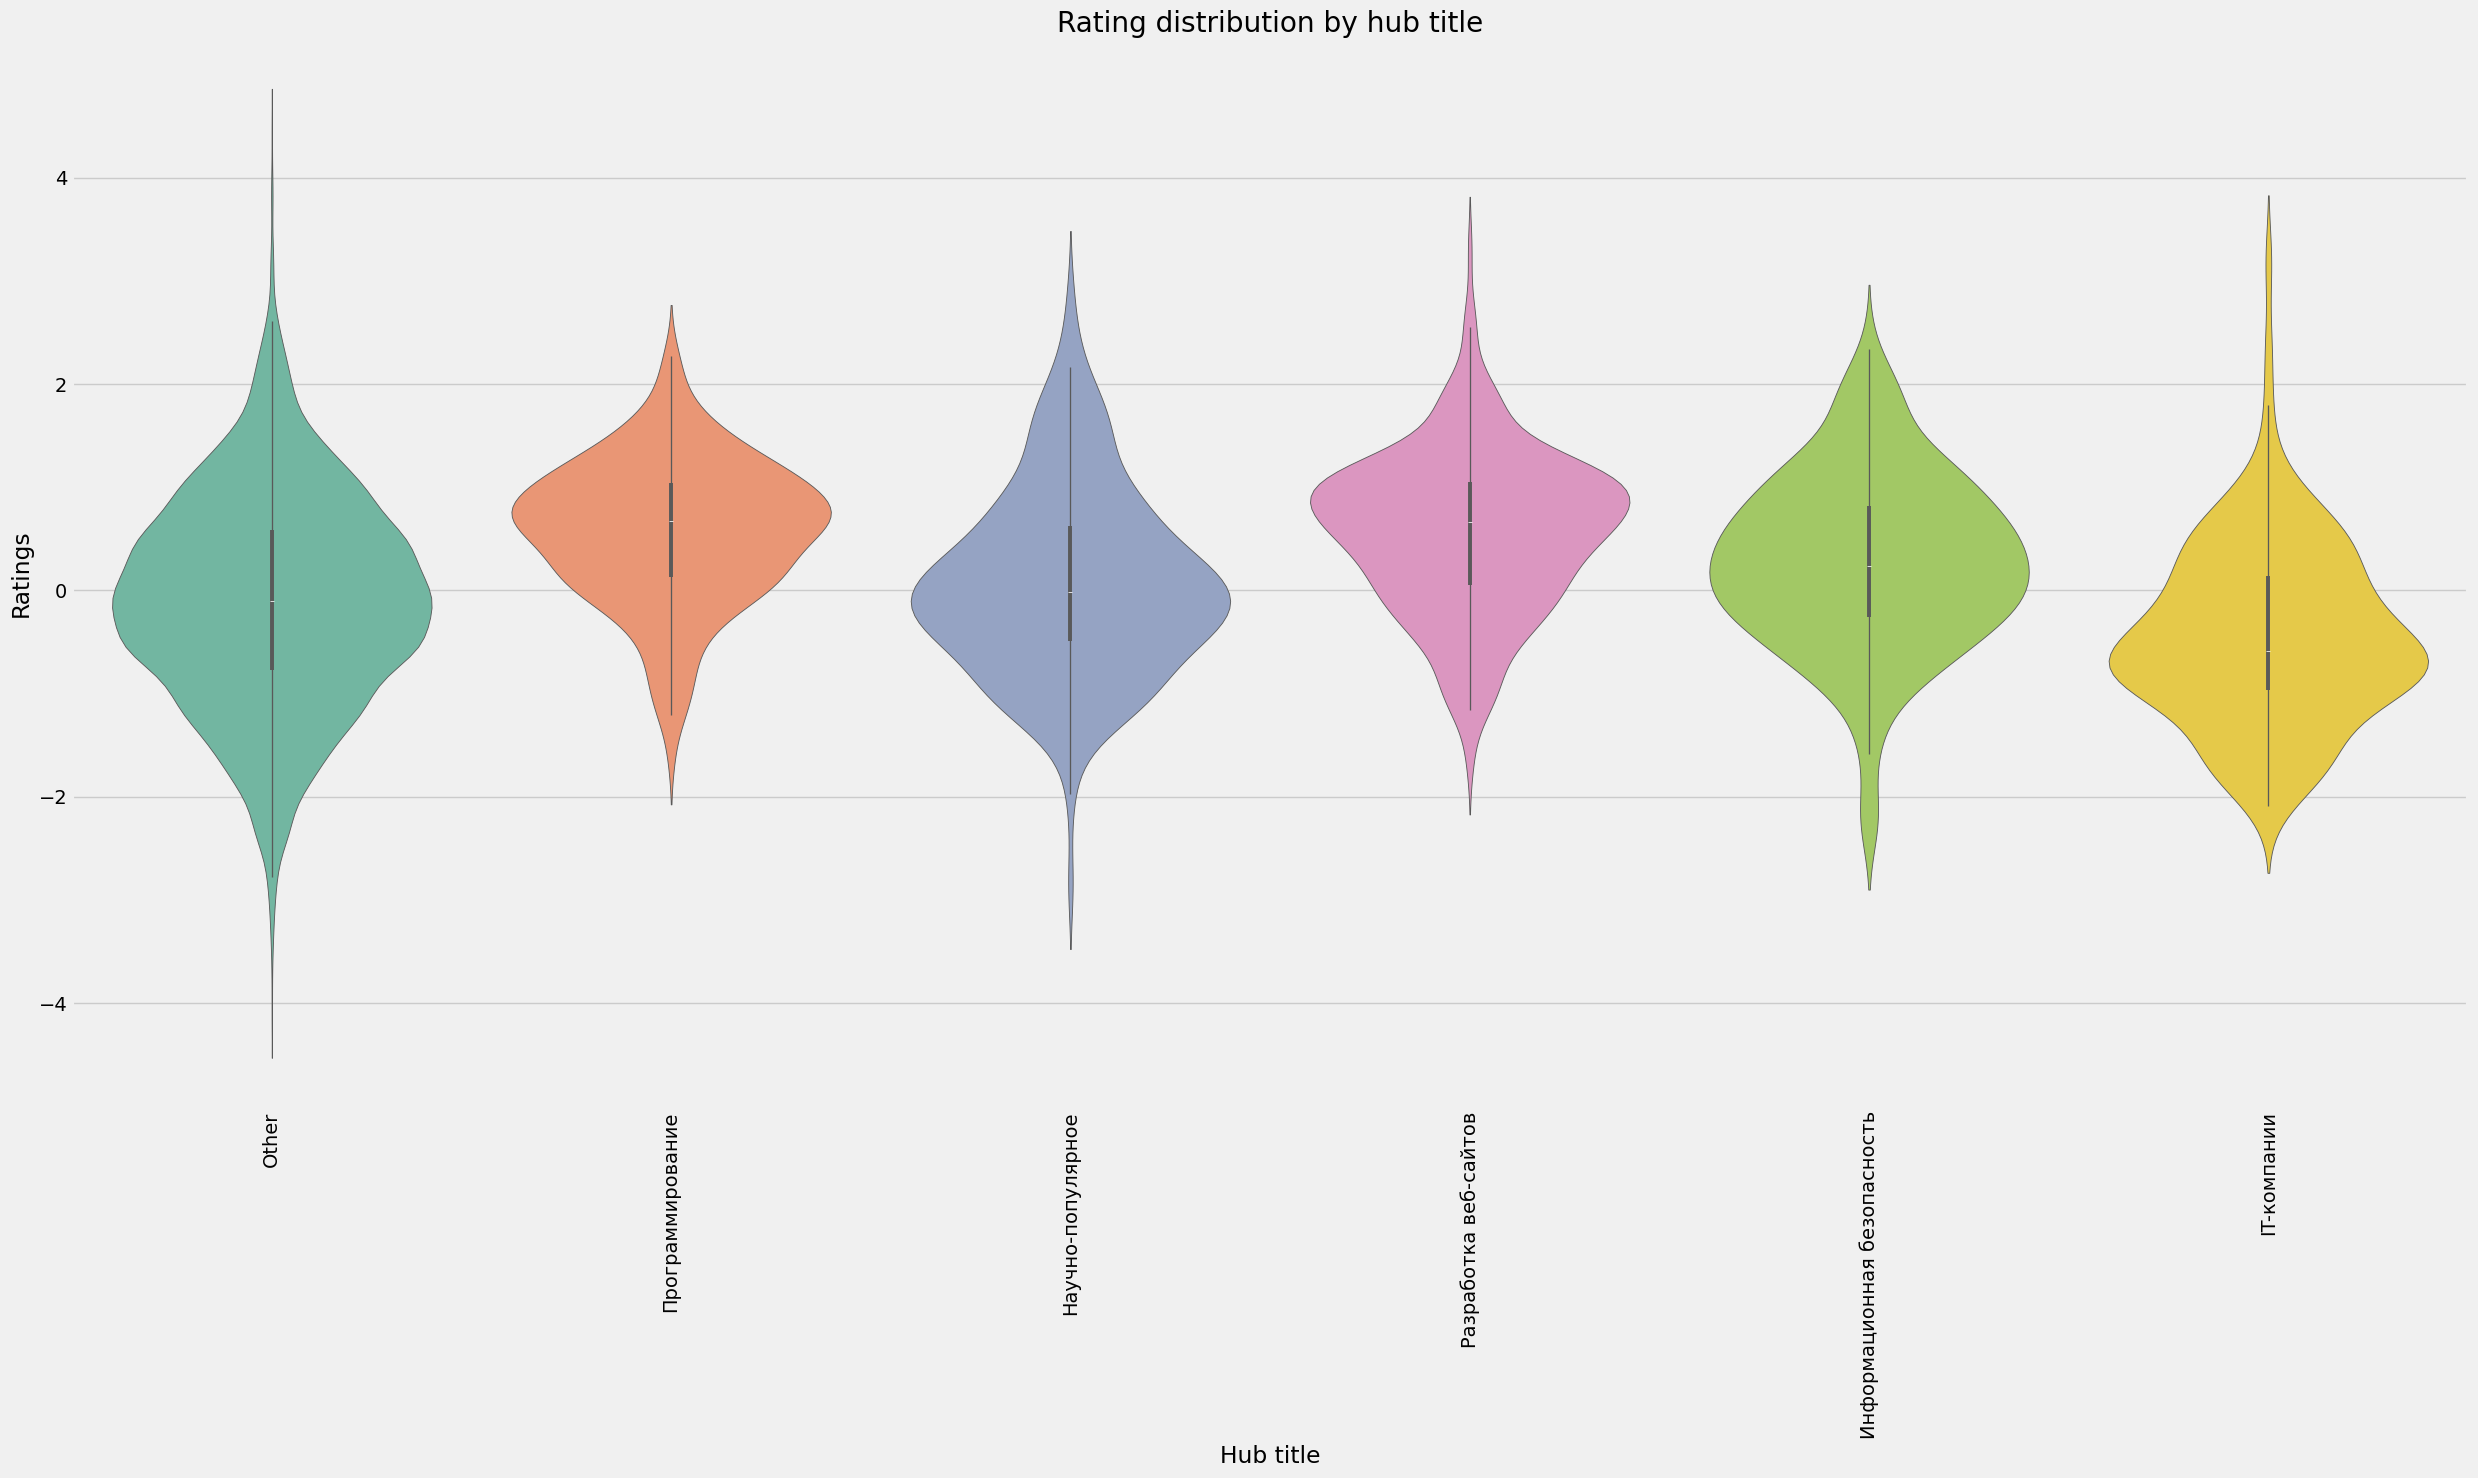

In [132]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.violinplot(x = "top_hubs", y = "favs_lognorm", data = svr_train, palette = "Set2")
plt.title("Rating distribution by hub title")
plt.xticks(rotation = 90)
plt.xlabel("Hub title")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating distribution by hub title.png', dpi = 300)

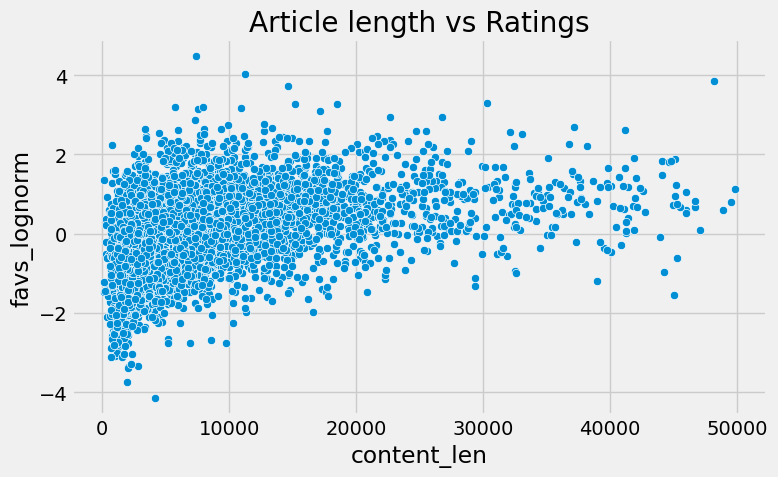

In [133]:
plt.figure(figsize = (8, 5))

plt.style.use('fivethirtyeight')
sns.scatterplot(x = 'content_len', y = 'favs_lognorm', data = svr_train[(svr_train['content_len'] > 30) & (svr_train['content_len'] < 50000)])
plt.title("Article length vs Ratings")
plt.tight_layout()
#plt.savefig('Article length vs Ratings.png', dpi = 300)

<ipython-input-134-e9f0dd52763e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "polling", y = "favs_lognorm", data = svr_train, palette = "coolwarm")


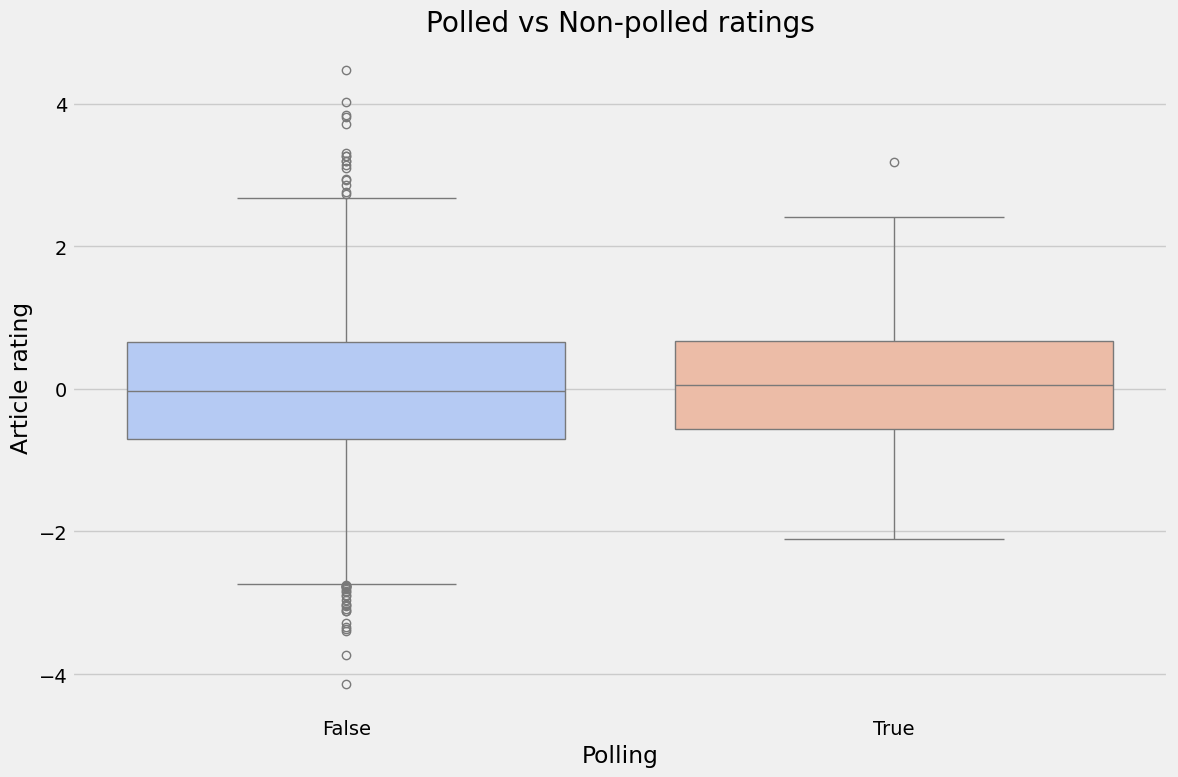

In [134]:
plt.figure(figsize = (12, 8))
sns.boxplot(x = "polling", y = "favs_lognorm", data = svr_train, palette = "coolwarm")
plt.title("Polled vs Non-polled ratings")
plt.xlabel('Polling')
plt.ylabel("Article rating")
plt.tight_layout()
#plt.savefig('Polled vs Non-polled ratings.png', dpi = 300)

In [135]:
svr_train['published'] = pd.to_datetime(svr_train['published'])

In [136]:
svr_train['dow'] = svr_train['published'].dt.dayofweek

<ipython-input-137-2312bc90d79c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = "dow", y = "favs_lognorm", data = svr_train, palette = "Set2")


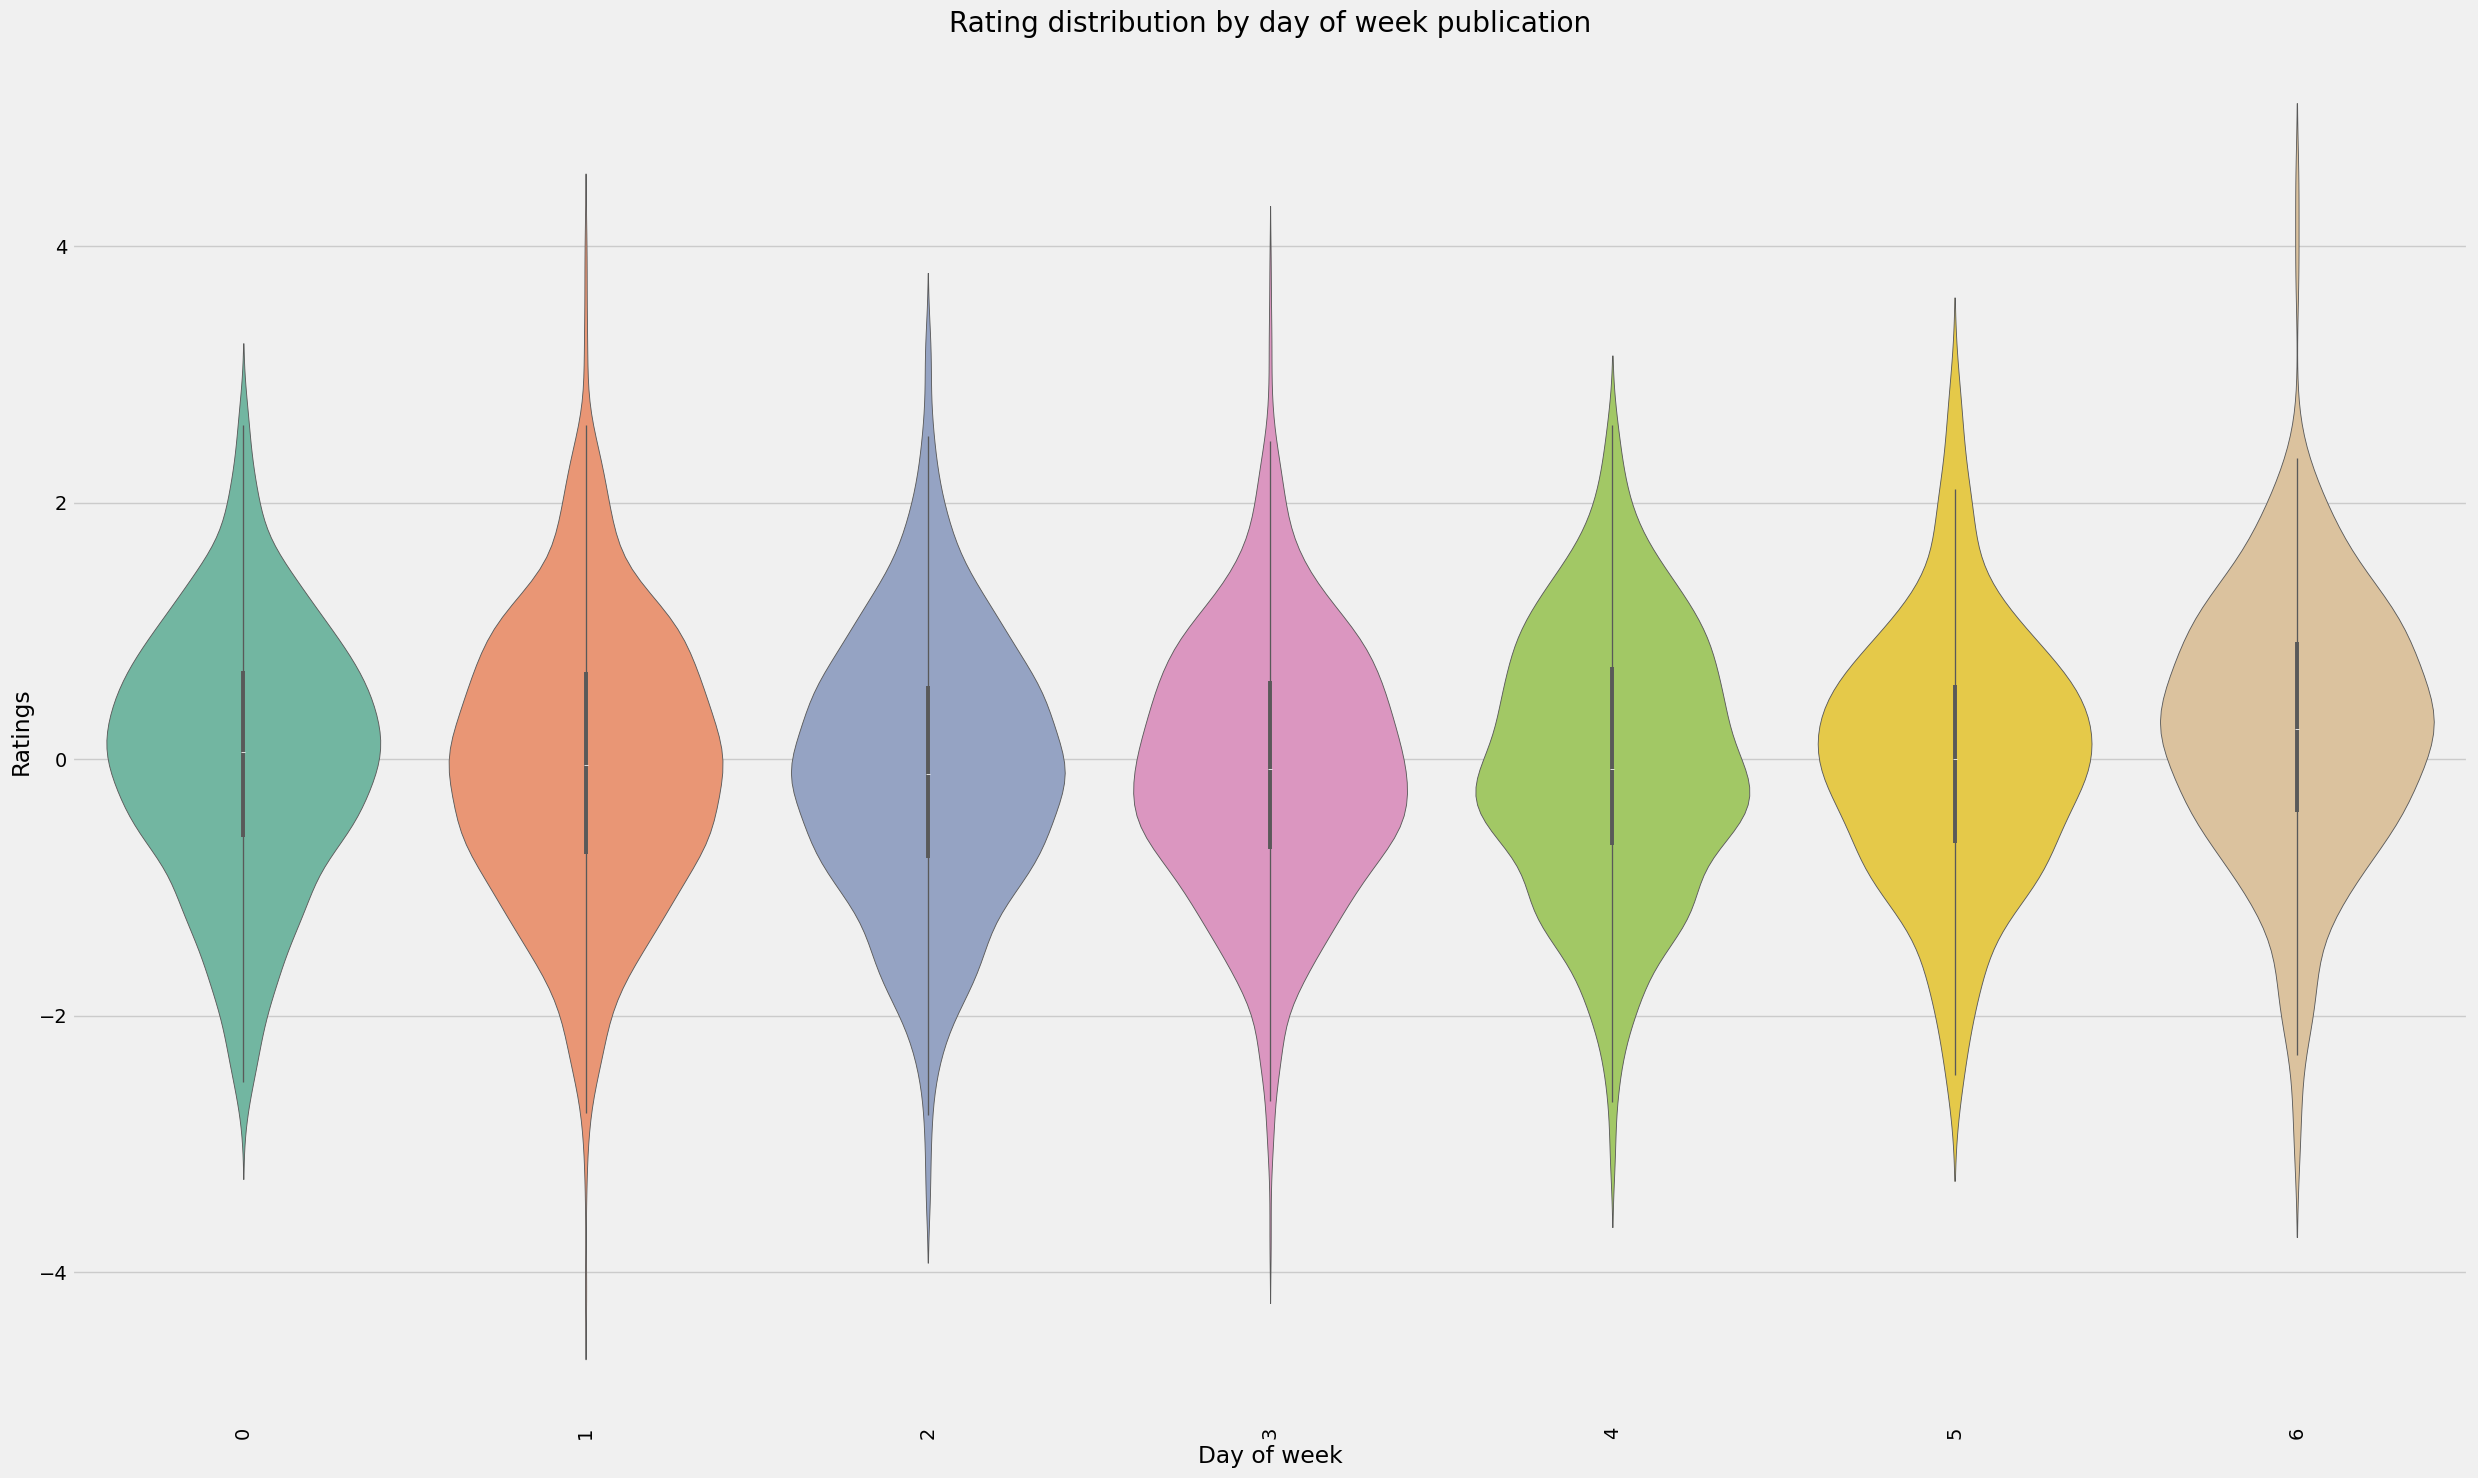

In [137]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.violinplot(x = "dow", y = "favs_lognorm", data = svr_train, palette = "Set2")
plt.title("Rating distribution by day of week publication")
plt.xticks(rotation = 90)
plt.xlabel("Day of week")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating distribution by day of week publication.png', dpi = 300)

In [138]:
svr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   url            4984 non-null   object        
 1   domain         4984 non-null   object        
 2   published      4984 non-null   datetime64[ns]
 3   author         3144 non-null   object        
 4   flow           4984 non-null   object        
 5   polling        4984 non-null   bool          
 6   content_len    4984 non-null   int64         
 7   title          4984 non-null   object        
 8   favs_lognorm   4984 non-null   float64       
 9   dataset        4984 non-null   object        
 10  hub_title      4984 non-null   object        
 11  tags           4984 non-null   object        
 12  content        4984 non-null   object        
 13  year           4984 non-null   int64         
 14  month          4984 non-null   int64         
 15  clean_content  4983 n

**Features:**

numerical:

- content_len

binary:

- domain
- polling

categorical:

- top_authors
- top_hubs
- dow
- flow

Use the XI correlation to determine if there is any relationship between our only continuous variable and the target.

In [139]:
#credit: https://towardsdatascience.com/a-new-coefficient-of-correlation-64ae4f260310

def xicor(X, Y, ties = True):
    random.seed(42)
    n = len(X)
    order = array([i[0] for i in sorted(enumerate(X), key=lambda x: x[1])])
    if ties:
        l = array([sum(y >= Y[order]) for y in Y[order]])
        r = l.copy()
        for j in range(n):
            if sum([r[j] == r[i] for i in range(n)]) > 1:
                tie_index = array([r[j] == r[i] for i in range(n)])
                r[tie_index] = random.choice(r[tie_index] - arange(0, sum([r[j] == r[i] for i in range(n)])), sum(tie_index), replace=False)
        return 1 - n*sum( abs(r[1:] - r[:n-1]) ) / (2*sum(l*(n - l)))
    else:
        r = array([sum(y >= Y[order]) for y in Y[order]])
        return 1 - 3 * sum( abs(r[1:] - r[:n-1]) ) / (n**2 - 1)

In [140]:
xicor(svr_train['content_len'], svr_train['favs_lognorm'])

0.1794811285149851

Use Cramér's V to measure association between various categorical features.

In [141]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [142]:
cat_features = ['domain', 'polling', 'top_authors', 'top_hubs', 'dow', 'flow']

cat_matrix = pd.DataFrame(index = svr_train[cat_features].columns, columns = svr_train[cat_features].columns)
columns = svr_train[cat_features].columns

for i in columns:
    for j in columns:

        cr = cramers_v(svr_train[i], svr_train[j])
        cat_matrix.loc[i, j] = cr


cat_matrix.fillna(value = np.nan, inplace = True)

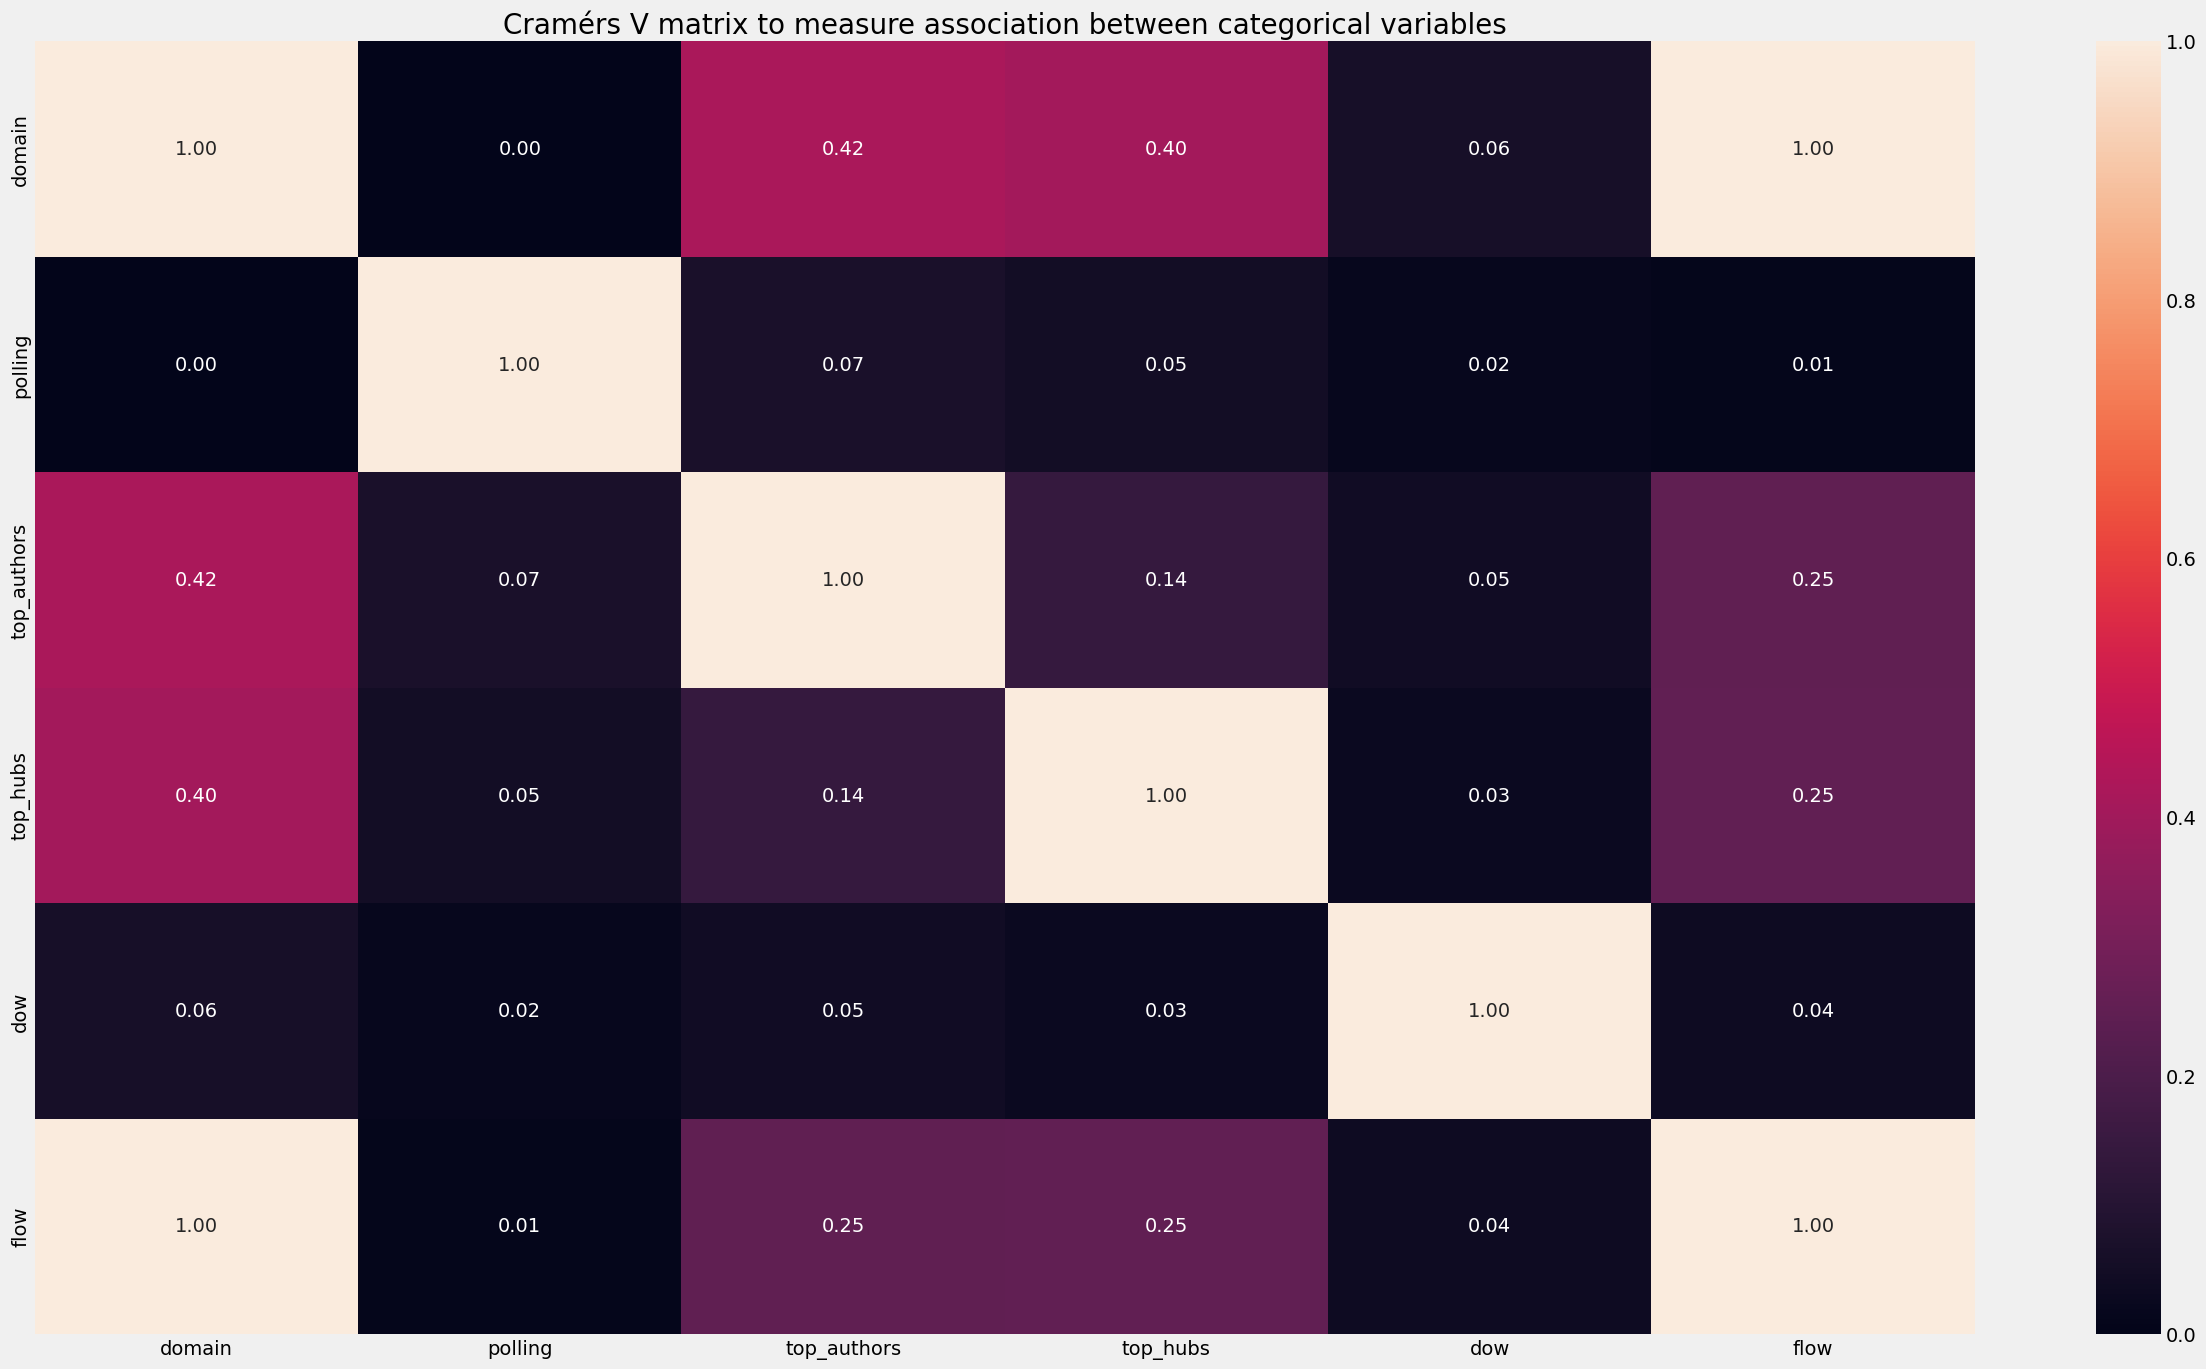

In [143]:
plt.figure(figsize = (25, 14))
sns.heatmap(cat_matrix.astype(float), annot = True, fmt = '.2f')
sns.set(font_scale = 1.4)
plt.title('Cramérs V matrix to measure association between categorical variables', size = 20)
plt.tight_layout()
#plt.savefig('Cramérs V matrix to measure association between categorical variables.png', dpi = 300)

In [144]:
svr_train[svr_train['domain'] == 'habrahabr.ru']['flow'].unique()

array(['admin', 'develop', 'marketing', 'misc', 'management', 'design'],
      dtype=object)

In [145]:
svr_train[svr_train['domain'] == 'geektimes.ru']['flow'].unique()

array(['Not specified'], dtype=object)

Looks like the flow variable basically contains all the information about domain. Depending on the feature importance, we could choose to use either domain or flow.

Let's choose a correlation measure to determine the strength of association, if any, between our binary variables (domain and polling) and the target variable. For this purpose, Point-Biserial Correlation could be suitable. However, our data has to meet certain assumptions for this measure to be yield valid results. These are:

- There should be no outliers for the continuous variable for each category of the binary variable.

- The continuous variable should be approximately normally distributed for each category of the binary variable. We can test this using the Shapiro-Wilk test of normality.

- The continuous variable should have equal variances for each category of the binary variable. We can test this using Levene's test of equality of variances.

<Figure size 2500x1500 with 0 Axes>

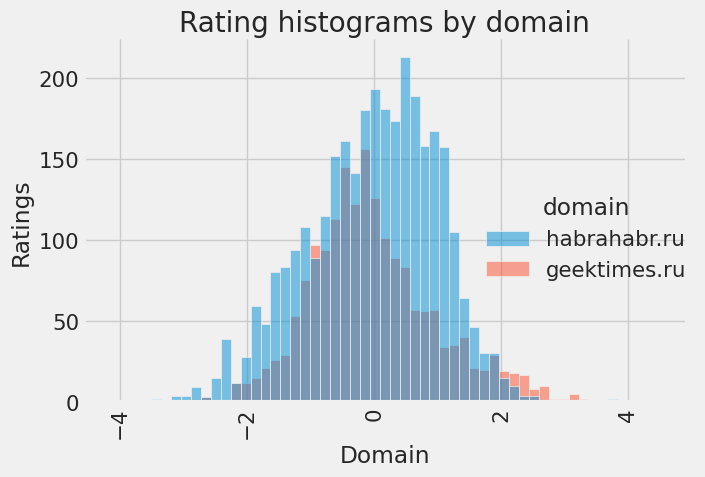

In [146]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.displot(data = svr_train, x = 'favs_lognorm', hue = 'domain')
plt.title("Rating histograms by domain")
plt.xticks(rotation = 90)
plt.xlabel("Domain")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating histograms by domain.png', dpi = 300)

In [147]:
domain1_data = svr_train[svr_train['domain'] == 'habrahabr.ru']['favs_lognorm']
domain2_data = svr_train[svr_train['domain'] == 'geektimes.ru']['favs_lognorm']

shapiro_domain1 = ss.shapiro(domain1_data)
shapiro_domain2 = ss.shapiro(domain2_data)

print("Shapiro-Wilk test for normality:")
print("Domain 1:", shapiro_domain1)
print("Domain 2:", shapiro_domain2)

# Test for equal variance using Levene's test
levene_test = ss.levene(domain1_data, domain2_data)

print("\nLevene's test for equal variance:")
print("Test statistic:", levene_test.statistic)
print("p-value:", levene_test.pvalue)

Shapiro-Wilk test for normality:
Domain 1: ShapiroResult(statistic=0.9895622730255127, pvalue=1.653070008081261e-14)
Domain 2: ShapiroResult(statistic=0.9778614640235901, pvalue=3.977991504501907e-16)

Levene's test for equal variance:
Test statistic: 7.657676761298477
p-value: 0.005673992287669086


Since both domain groups appear to deviate from a normal distribution and exhibit unequal variances, using the Point-Biserial Correlation might not yield reliable results. I propose employing the Mann–Whitney U test instead to assess whether there's a significant statistical difference between the two domains. If such a difference exists, it would be prudent to consider the domain feature when predicting the target variable.

In [148]:
domain1_data = svr_train[svr_train['domain'] == 'habrahabr.ru']['favs_lognorm']
domain2_data = svr_train[svr_train['domain'] == 'geektimes.ru']['favs_lognorm']

calc = ss.mannwhitneyu(domain1_data, domain2_data)[1]

print(f'Mann–Whitney U test p-value for favs_lognorm based on domain: {calc}')

Mann–Whitney U test p-value for favs_lognorm based on domain: 0.009342130376426224


There appears to be a significant difference between the two domain groups. It would be reasonable to use the domain variable for further feature selection.

Let's do the same for the polling feature.

<Figure size 2500x1500 with 0 Axes>

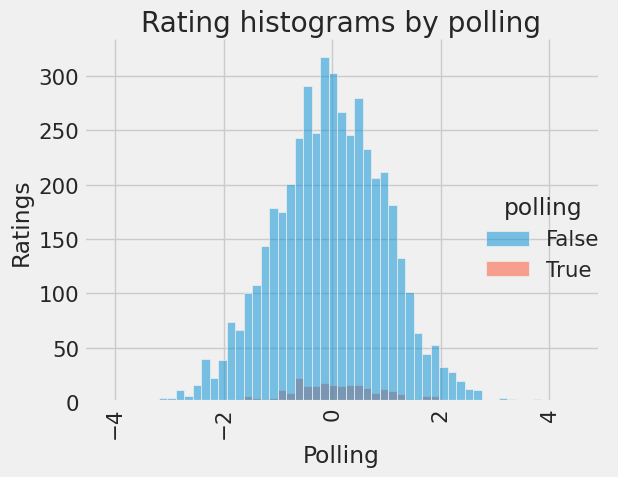

In [149]:
plt.figure(figsize = (25, 15))
plt.style.use('fivethirtyeight')
sns.displot(data = svr_train, x = 'favs_lognorm', hue = 'polling')
plt.title("Rating histograms by polling")
plt.xticks(rotation = 90)
plt.xlabel("Polling")
plt.ylabel("Ratings")
plt.tight_layout()
#plt.savefig('Rating histograms by polling.png', dpi = 300)

In [150]:
polling1_data = svr_train[svr_train['polling'] == True]['favs_lognorm']
polling2_data = svr_train[svr_train['polling'] == False]['favs_lognorm']

shapiro_polling1 = ss.shapiro(polling1_data)
shapiro_polling2 = ss.shapiro(polling2_data)

print("Shapiro-Wilk test for normality:")
print("Polling = True:", shapiro_polling1)
print("Polling = False:", shapiro_polling2)

# Test for equal variance using Levene's test
levene_test = ss.levene(polling1_data, polling2_data)

print("\nLevene's test for equal variance:")
print("Test statistic:", levene_test.statistic)
print("p-value:", levene_test.pvalue)

Shapiro-Wilk test for normality:
Polling = True: ShapiroResult(statistic=0.9938480257987976, pvalue=0.4058336913585663)
Polling = False: ShapiroResult(statistic=0.9990806579589844, pvalue=0.01178707368671894)

Levene's test for equal variance:
Test statistic: 3.7760713709416422
p-value: 0.052046847080462776


We could attempt to apply the point-biserial correlation to measure the association between the polling variable and the target variable. Based on the correlation value, it appears to be negligible.

In [151]:
corr_polling, _ = ss.pointbiserialr(svr_train['polling'], svr_train['favs_lognorm'])

print("Point-Biserial Correlation (polling, favs_lognorm):", corr_polling)

Point-Biserial Correlation (polling, favs_lognorm): 0.029535224630463205


Let's now perform an ANOVA test to determine correlation, if any, between the rest of the catergorical variables and the target.

In [152]:
anova_cat_features = ['top_authors', 'top_hubs', 'dow', 'flow']

anova_est = svr_train.copy()

In [153]:
for col in anova_cat_features:

    if col != 'dow':

      le = LabelEncoder()

      anova_est[col] = le.fit_transform(anova_est[col])

In [154]:
fs = SelectKBest(score_func = f_regression, k = 'all')
fs.fit(anova_est[anova_cat_features], anova_est['favs_lognorm'])

SelectKBest(k='all', score_func=<function f_regression at 0x7e0396977880>)

Feature 0: 160.646847
Feature 1: 192.260863
Feature 2: 4.665080
Feature 3: 190.300663


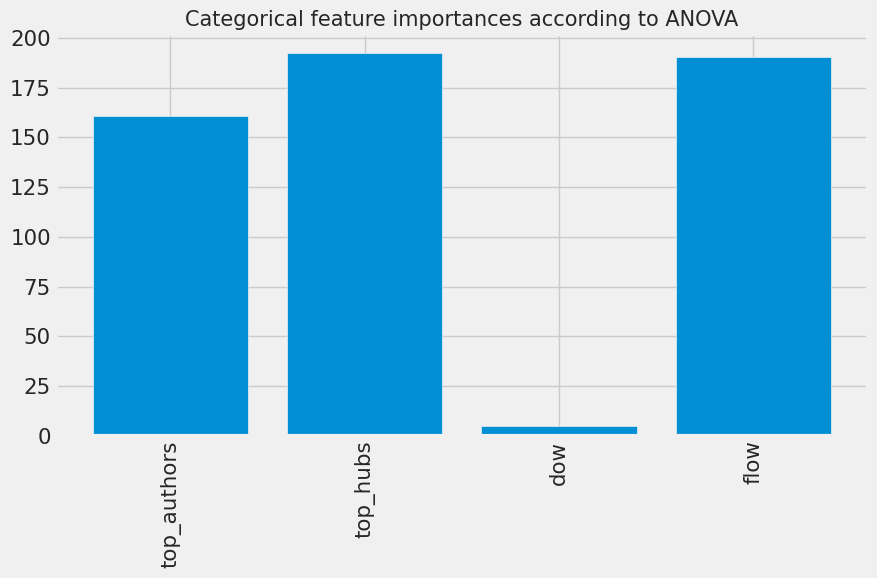

In [155]:
plt.figure(figsize = (9, 6))
plt.xticks(ticks = np.arange(0, 4),
           labels = anova_cat_features,
           rotation = 90)
plt.title('Categorical feature importances according to ANOVA', size = 15)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.tight_layout()
#plt.savefig('Categorical feature importances according to ANOVA.png', dpi = 300)

Let's use a LightGBM regressor to estimate the final importances of all the additional features.

In [156]:
lgbm_dataset = svr_train.copy()

In [157]:
lgbm_features = ['content_len', 'domain', 'polling', 'top_authors', 'top_hubs', 'dow', 'flow']

In [158]:
X = lgbm_dataset[lgbm_features]
y = lgbm_dataset['favs_lognorm']

In [159]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 99)

In [160]:
params = {'objective': 'regression',
          'metric': 'MAE',
          'max_depth': 4,
          'n_estimators': 100,
          'num_leaves': 31,
          'learning_rate': 0.1,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'early_stopping_rounds': 10,
          'random_state': 77,
          'n_jobs': -1
         }

In [161]:
for col in lgbm_features[1:]:

  if col != 'dow':

      le = LabelEncoder()

      X_train[col] = le.fit_transform(X_train[col])
      X_val[col] = le.transform(X_val[col])

In [162]:
lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_val = lgb.Dataset(X_val, label = y_val, reference = lgb_train)

In [163]:
lgbm_regressor = lgb.train(params,
                           lgb_train,
                           valid_sets = lgb_val,
                           categorical_feature = [1, 2, 3, 4, 5, 6])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 3987, number of used features: 7
[LightGBM] [Info] Start training from score -0.047617
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Text(0.5, 1.0, 'LightGBM feature importances')

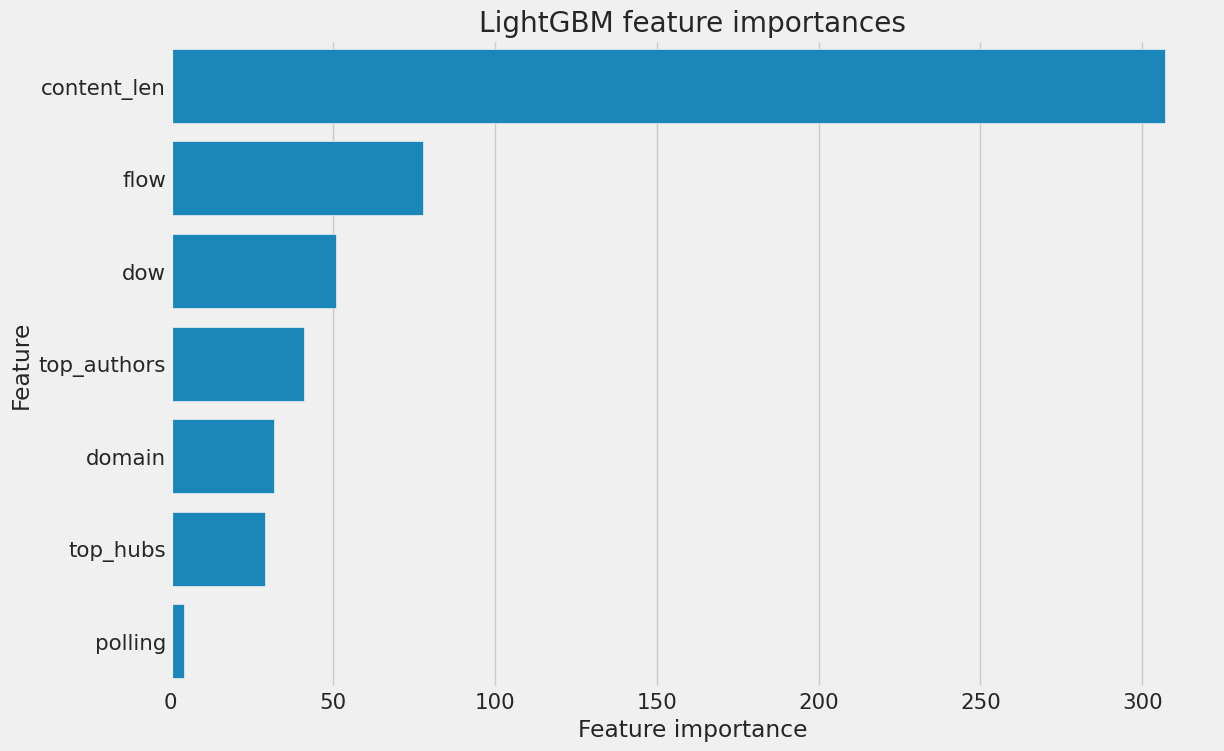

In [164]:
feature_importances = lgbm_regressor.feature_importance()

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importance = feature_importances[sorted_indices]
sorted_feature_names = np.array(X_val.columns)[sorted_indices]

fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = sorted_feature_importance, y = sorted_feature_names, ax = ax)
ax.set(xlabel = 'Feature importance', ylabel = 'Feature')
ax.set_title('LightGBM feature importances')
#plt.savefig('LightGBM feature importances.png', dpi = 300)

After performing feature selection with all of the above methods, it seems reasonable to use the following features along with BERT embeddings to train the final SVR model:

- content_len
- flow
- top_authors
- top_hubs

We will additionally develop a function to process the title column. Subsequently, we will train a FastText model on it to generate concise embeddings. These embeddings will serve as supplementary features during the training of an SVR model.

In [165]:
svr_train['title'].sample(50).tolist()

['Релиз СУБД InterSystems Caché 2015.1',
 'Корпус MSI Dragon — восстановить за 100 часов',
 'Docker. Best practices на примере образа Oracle xe 11g',
 'Visual Studio Online. Что это такое и с чем её едят?',
 'Создание плагинов для AutoCAD с помощью .NET API (часть 5 – знакомство с блоками)',
 'Ностальгия по КУВТ: ретроспектива средств разработки для 8-битных компьютеров MSX. Часть 1 — языки, редакторы, трансляторы',
 'Готовим к публикации пост с формулами',
 'Почему вам надо обновить свои SSL сертификаты',
 'Что под капотом у динамической магнитной полосы?',
 'Американские астронавты делились рационами с российскими коллегами. Авария «Прогресса» привела к дефициту продуктов и медикаментов на МКС',
 'Приглашаем потестировать обновленный дизайн Альфа-Мобайла',
 'Разработка на ES6 для браузеров',
 'Chromebit превратит любой монитор или ТВ в полноценный компьютер за $85',
 'Mikrotik RouterOS + PHP скрипт на сайте. Расширение возможностей',
 'Искусственный интеллект совершил реверс-инжинири

The text cleaning function would remove any non-letter characters from the titles and then lemmatize the tokens.

In [166]:
bad_symbols = re.compile("[^а-яА-Яa-zA-Z]")
stop_words = set(stopwords.words("english")) | set(stopwords.words("russian"))

def clean_text_fasstext(text):

    clean_text = bad_symbols.sub(' ', text)
    clean_text = clean_text.lower().split()
    clean_text = [lemmatize(word, lang = ('ru', 'en')) for word in clean_text if (word not in stop_words) and (len(lemmatize(word, lang = ('ru', 'en')))) > 3]
    clean_text = ' '.join(clean_text)
    return clean_text

In [167]:
tqdm.pandas()

In [168]:
svr_train['clean_title'] = svr_train['title'].progress_apply(clean_text_fasstext)

100%|██████████| 4984/4984 [00:00<00:00, 58121.09it/s]


In [169]:
svr_train['clean_title'].sample(50).tolist()

['видеоучитель smart english изучать язык язык правильный',
 'след конференция azurecon главное анонс',
 'konva html canvas framework',
 'маленький секрет большой колл центр предиктивный обзвон',
 'российский фестиваль круг свет книга рекорд гиннесса',
 'создать правильный описание вакансия',
 'новый буквой электронный словарь украинский язык',
 'защита право база данные',
 'исландский стартап предлагать протеин батончик насекомое',
 'способ перестать терять благородий клиент',
 'microventures венчурные инвестиция масса',
 'фонд бортник планировать вложить рубль стартап mobiforce',
 'Microsoft показать project astoria выглядеть использование android window приложение',
 'hackersim небольшой разъяснение комментарий',
 'задержка рейс сентябрь авиакомпания мочь прекратить бронировать билет',
 'оборотный сторона безвозмездный пряник грант выигрыш конкурс безвозмездный пользование ресурс заём кредит',
 'совет понимать запоминать долгий',
 'amazon смочь летать космос испытание новое двигател

The idea of training a FastText model to obtain embeddings of the article titles is as follows.

In [170]:
fasttext_model = FastText(vector_size = 8, window = 3, min_count = 3)
fasttext_model.build_vocab(corpus_iterable = svr_train['clean_title'].apply(lambda x: x.split(' ')))

In [171]:
vocab = fasttext_model.wv
vocabulary_words = list(vocab.key_to_index.keys())

In [172]:
len(vocabulary_words)

2179

In [173]:
vocabulary_words[:10]

['часть',
 'новый',
 'приложение',
 'google',
 'работа',
 'который',
 'разработчик',
 'система',
 'компания',
 'обзор']

In [174]:
fasttext_model.train(corpus_iterable = svr_train['clean_title'].apply(lambda x: x.split(' ')), total_examples = len(svr_train), epochs = 10)

(185447, 275460)

In [175]:
fasttext_vecs = svr_train['clean_title'].progress_apply(lambda x: np.mean([fasttext_model.wv[y] for y in x.split(' ')], axis = 0))

100%|██████████| 4984/4984 [00:00<00:00, 10549.47it/s]


In [176]:
np.array(fasttext_vecs.to_list())

array([[-0.2582752 ,  0.04019472,  0.17964967, ..., -0.07394052,
         0.44246206,  0.46348345],
       [-1.2595371 ,  0.17201212,  0.8290513 , ..., -0.26614967,
         2.0267367 ,  2.1201797 ],
       [-1.0262916 ,  0.16182077,  0.6750062 , ..., -0.20998533,
         1.6743108 ,  1.740454  ],
       ...,
       [-1.3270967 ,  0.18784602,  0.87482005, ..., -0.2529812 ,
         2.121053  ,  2.1906898 ],
       [-0.48816577,  0.07404133,  0.35342982, ..., -0.09085219,
         0.83135206,  0.8411419 ],
       [-0.68628734,  0.09229019,  0.45339027, ..., -0.154213  ,
         1.1347429 ,  1.1774535 ]], dtype=float32)

Let's implement a new function for hyperparameter search that can accurately conduct cross-validation. This includes incorporating not only BERT embeddings but also the 'content_len' variable, multiple categorical variables requiring encoding, and FastText title embeddings.

In [177]:
X = svr_train[['embeddings', 'content_len', 'flow', 'top_authors', 'top_hubs', 'clean_title']]
y = svr_train['favs_lognorm']

In [178]:
def convert_to_list(embedding_str):

  embedding_str = embedding_str.strip('[]')
  numbers = [float(num) for num in embedding_str.split()]

  return numbers

In [179]:
def objective(trial):

    C = trial.suggest_float('C', 0.001, 10.0, log = True)
    gamma = trial.suggest_float('gamma', 0.005, 10.0, log = True)

    model = SVR(kernel = 'rbf', C = C, gamma = gamma)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 87)

    mse_scores = []

    for train_index, val_index in kf.split(X):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_embeddings = np.array(X_train['embeddings'].apply(convert_to_list).to_list())
        X_val_embeddings = np.array(X_val['embeddings'].apply(convert_to_list).to_list())

        fasttext_model = FastText(vector_size = 8, window = 3, min_count = 3)
        fasttext_model.build_vocab(corpus_iterable = X_train['clean_title'].apply(lambda x: x.split(' ')))
        fasttext_model.train(corpus_iterable = X_train['clean_title'].apply(lambda x: x.split(' ')), total_examples = len(X_train), epochs = 10)
        X_train_fasttext_vecs = X_train['clean_title'].apply(lambda x: np.mean([fasttext_model.wv[y] for y in x.split(' ')], axis = 0))
        X_train_fasttext_embeddings = np.array(X_train_fasttext_vecs.to_list())
        X_val_fasttext_vecs = X_val['clean_title'].apply(lambda x: np.mean([fasttext_model.wv[y] for y in x.split(' ')], axis = 0))
        X_val_fasttext_embeddings = np.array(X_val_fasttext_vecs.to_list())

        X_train_features = X_train[['content_len', 'flow', 'top_authors', 'top_hubs']].copy()
        X_val_features = X_val[['content_len', 'flow', 'top_authors', 'top_hubs']].copy()

        scaler = StandardScaler()
        X_train_features['content_len'] = scaler.fit_transform(X_train_features[['content_len']])
        X_val_features['content_len'] = scaler.transform(X_val_features[['content_len']])

        encoder = BinaryEncoder(cols = ['flow', 'top_authors', 'top_hubs'])
        X_train_encoded = encoder.fit_transform(X_train_features)
        X_val_encoded = encoder.transform(X_val_features)

        X_train_encoded = X_train_encoded.to_numpy()
        X_val_encoded = X_val_encoded.to_numpy()

        # print(f'Embeddings train shape: {X_train_embeddings.shape}')
        # print(f'FastText embeddings train shape: {X_train_fasttext_embeddings.shape}')
        # print(f'Features train shape: {X_train_encoded.shape}')

        X_train = np.concatenate((X_train_embeddings, X_train_fasttext_embeddings, X_train_encoded), axis = 1)
        X_val = np.concatenate((X_val_embeddings, X_val_fasttext_embeddings, X_val_encoded), axis = 1)

        # print(f'Concatenated train shape: {X_train.shape}')

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = np.mean((y_val - y_pred) ** 2)
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)

    return avg_mse

In [ ]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 20)

best_params = study.best_params
best_mse = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)

[I 2024-04-17 14:57:48,485] A new study created in memory with name: no-name-f86d4539-568d-4962-a107-226f59b265bf
[I 2024-04-17 14:59:05,261] Trial 0 finished with value: 0.5673708404718273 and parameters: {'C': 0.07797350412371867, 'gamma': 0.2159810771302752}. Best is trial 0 with value: 0.5673708404718273.
[I 2024-04-17 15:00:16,488] Trial 1 finished with value: 0.9108932544111713 and parameters: {'C': 0.004057370097519124, 'gamma': 0.22252733036220132}. Best is trial 0 with value: 0.5673708404718273.
[I 2024-04-17 15:01:32,663] Trial 2 finished with value: 0.9559723071421249 and parameters: {'C': 0.0013837284862385664, 'gamma': 0.014788880939450444}. Best is trial 0 with value: 0.5673708404718273.
[I 2024-04-17 15:02:47,331] Trial 3 finished with value: 0.5647957474831036 and parameters: {'C': 0.06933675714253133, 'gamma': 0.018056679751920452}. Best is trial 3 with value: 0.5647957474831036.
[I 2024-04-17 15:03:59,698] Trial 4 finished with value: 0.8094385583199493 and parameters

Best Hyperparameters: {'C': 1.0488712562303886, 'gamma': 0.10201707591435619}
Best Mean Squared Error: 0.46943307424145353


In [ ]:
# Best Hyperparameters: {'C': 1.0488712562303886, 'gamma': 0.10201707591435619}
# Best Mean Squared Error: 0.46943307424145353

Let's train the best model on the whole dataset and evaluate its performance on the test set.

In [180]:
X_train = svr_train[['embeddings', 'content_len', 'flow', 'top_authors', 'top_hubs', 'clean_title']]
y_train = svr_train['favs_lognorm']

In [181]:
X_train_embeddings = np.array(X_train['embeddings'].apply(convert_to_list).to_list())
X_train_features = X_train[['content_len', 'flow', 'top_authors', 'top_hubs']].copy()

fasttext_model = FastText(vector_size = 8, window = 3, min_count = 3)
fasttext_model.build_vocab(corpus_iterable = X_train['clean_title'].apply(lambda x: x.split(' ')))
fasttext_model.train(corpus_iterable = X_train['clean_title'].apply(lambda x: x.split(' ')), total_examples = len(X_train), epochs = 10)
X_train_fasttext_vecs = X_train['clean_title'].apply(lambda x: np.mean([fasttext_model.wv[y] for y in x.split(' ')], axis = 0))
X_train_fasttext_embeddings = np.array(X_train_fasttext_vecs.to_list())

scaler = StandardScaler()
X_train_features['content_len'] = scaler.fit_transform(X_train_features[['content_len']])

encoder = BinaryEncoder(cols = ['flow', 'top_authors', 'top_hubs'])
X_train_encoded = encoder.fit_transform(X_train_features)

X_train_encoded = X_train_encoded.to_numpy()

X_train = np.concatenate((X_train_embeddings, X_train_fasttext_embeddings, X_train_encoded), axis = 1)

In [182]:
X_train.shape

(4984, 786)

In [183]:
svr_model = SVR(kernel = 'rbf', C = 1.0488712562303886, gamma = 0.10201707591435619)

In [184]:
svr_model.fit(X_train, y_train)

SVR(C=1.0488712562303886, gamma=0.10201707591435619)

In [185]:
svr_test = pd.read_csv('gdrive/MyDrive/ML/projects/svr_test.csv')

In [186]:
svr_test['top_authors'] = svr_test['author']
svr_test.loc[~svr_test['top_authors'].isin(top_authors.index.tolist()), 'top_authors'] = 'Other'

svr_test['top_hubs'] = svr_test['hub_title']
svr_test.loc[~svr_test['top_hubs'].isin(top_hubs.index.tolist()), 'top_hubs'] = 'Other'

In [187]:
svr_test['clean_title'] = svr_test['title'].progress_apply(clean_text_fasstext)

100%|██████████| 7540/7540 [00:00<00:00, 58908.33it/s]


In [188]:
X_test = svr_test[['embeddings', 'content_len', 'flow', 'top_authors', 'top_hubs', 'clean_title']]
y_test = svr_test['favs_lognorm']

In [189]:
X_test_embeddings = np.array(X_test['embeddings'].apply(convert_to_list).to_list())
X_test_features = X_test[['content_len', 'flow', 'top_authors', 'top_hubs']].copy()

In [190]:
X_test_fasttext_vecs = X_test['clean_title'].apply(lambda x: np.mean([fasttext_model.wv[y] for y in x.split(' ')], axis = 0))
X_test_fasttext_embeddings = np.array(X_test_fasttext_vecs.to_list())

In [191]:
X_test_features['content_len'] = scaler.transform(X_test_features[['content_len']])
X_test_encoded = encoder.transform(X_test_features)

X_test_encoded = X_test_encoded.to_numpy()

X_test = np.concatenate((X_test_embeddings, X_test_fasttext_embeddings, X_test_encoded), axis = 1)

In [192]:
y_train_preds = svr_model.predict(X_train)

In [193]:
y_test_preds = svr_model.predict(X_test)

In [194]:
svm_train_metrics_add_features = calc_regression_metrics(y_train, y_train_preds, 'SVM train additional features')

In [195]:
svm_test_metrics_add_features = calc_regression_metrics(y_test, y_test_preds, 'SVM test additional features')

In [196]:
svm_train_metrics_add_features

,SVM train additional features
Mean Absolute Error,0.298774
Mean Squared Error,0.212284
Mean Absolute Percentage Error,1.132545


In [197]:
svm_test_metrics_add_features

,SVM test additional features
Mean Absolute Error,0.538536
Mean Squared Error,0.483675
Mean Absolute Percentage Error,3.547625


In [199]:
pd.concat([lstm_test_metrics, svm_test_metrics, svm_test_metrics_add_features], axis = 1)

,LSTM test,SVM test,SVM test additional features
Mean Absolute Error,0.602865,0.585878,0.538536
Mean Squared Error,0.592548,0.563253,0.483675
Mean Absolute Percentage Error,3.723481,3.407713,3.547625


We can see that by incorporating additional numerical and categorical features plus title embeddings, we have been able to further improve the performance of the model on the test set.

In conclusion, this research showcases a novel approach in natural language processing through the adaptation of a custom LoRA implementation of the original BERT attention layers. By integrating this tailored model, we not only achieved significantly accelerated model training but also successfully obtained high-quality text embeddings by fine-tuning on a Masked Language Model (MLM) task.

The comparative analysis revealed that traditional methodologies like LSTM, even when provided with a larger training subset, lagged behind our custom LoRA-based model in performance metrics. This underscores the efficacy and innovation brought about by our custom implementation in advancing the field of NLP.

Furthermore, the utilization of Optuna for hyperparameter search proved instrumental in optimizing model performance and enhancing efficiency. By leveraging this powerful tool, we were able to fine-tune our model effectively, leading to improved accuracy and robustness.

Additionally, the meticulous feature selection process undertaken in this study unearthed valuable categorical features that, when incorporated, further bolstered the model's performance. This strategic selection not only enhanced predictive capabilities but also highlighted the importance of feature engineering in building successful machine learning models.

In essence, this research not only advances the domain of natural language processing but also underscores the significance of innovative model architectures, strategic hyperparameter tuning, and meticulous feature selection in optimizing performance and achieving groundbreaking results in data science and machine learning applications.